In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat as loadmat
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False

# Suppress warnings`
warnings.filterwarnings("ignore")

In [4]:
import xy

In [2279]:
import imp
imp.reload(xy)

<module 'xy' from 'E:\\PyProject\\factors\\UMR\\xy.py'>

# $因子描述：UMR$

***计算每个标的换手率多头组合的收益率，即标的放量收益率和缩量收益率之差***  
从个股上看，换手多空动量是一个空头指标，这意味着过去20日内，**出现放量下跌且缩量上涨的标的更有可能在次日上涨**，而在指数强弱上体现了相反的规律，以此为切入点改进“个股 —— 指数”的映射方式。

1. 数据：股票日线行情、换手率  
2. 滚动20日，使用换手率最高的5日，和换手最低的五日收益率作为样本，分别计算其收益率均值得到 arr5 和 arr1；
3. arr5-arr1得到换手多空动量。
4. **在映射到指数的过程中，剔除中间噪声标的**

## 计算

In [736]:
TR300 = (pd.concat([
    (xy.index_high.T['300'] - xy.index_low.T['300']),
    (xy.index_high.T['300'] - xy.cl.T['300'].shift(1)).abs(),
    (xy.cl.T['300'].shift(1) - xy.index_low.T['300']).abs()
],axis=1)).dropna(how='all').max(axis=1).rename('300')/xy.cl.T['300']
TR50 = (pd.concat([
    (xy.index_high.T['50'] - xy.index_low.T['50']),
    (xy.index_high.T['50'] - xy.cl.T['50'].shift(1)).abs(),
    (xy.cl.T['50'].shift(1) - xy.index_low.T['50']).abs()
],axis=1)).dropna(how='all').max(axis=1).rename('50')/xy.cl.T['50']
TR500 = (pd.concat([
    (xy.index_high.T['500'] - xy.index_low.T['500']),
    (xy.index_high.T['500'] - xy.cl.T['500'].shift(1)).abs(),
    (xy.cl.T['500'].shift(1) - xy.index_low.T['500']).abs()
],axis=1)).dropna(how='all').max(axis=1).rename('500')/xy.cl.T['500']
TR1000 = (pd.concat([
    (xy.index_high.T['1000'] - xy.index_low.T['1000']),
    (xy.index_high.T['1000'] - xy.cl.T['1000'].shift(1)).abs(),
    (xy.cl.T['1000'].shift(1) - xy.index_low.T['1000']).abs()
],axis=1)).dropna(how='all').max(axis=1).rename('1000')/xy.cl.T['1000']
# ATR300 = TR.rolling(15).mean().dropna()

In [1075]:
DN = (xy.cl - xy.op) / xy.op
ON = (xy.op - xy.cl.shift(axis=1)) / xy.cl.shift(axis=1)
# ATR300 = TR.rolling(15).mean().dropna()

In [1022]:
DN.T[['50', '300', '500', '1000']].dropna()

50      300      500     1000
2005-01-04  -9.9170 -11.9760  -9.7550  -6.2940
2005-01-05   5.7210  10.9840  17.0630  23.7100
2005-01-06  -9.4900 -10.1560  -8.8950  -9.5000
2005-01-07   0.9470   0.9080   4.1720   6.2250
2005-01-10   9.2200  10.1190   9.4090  11.7130
...             ...      ...      ...      ...
2023-05-04  29.2394  16.7758  39.1630  32.4788
2023-05-05 -13.4165 -14.2172 -55.1285 -69.5064
2023-05-08  25.7555  34.5568  45.9041  41.5833
2023-05-09 -19.2507 -37.5636 -60.6858 -85.0315
2023-05-10 -24.8598 -21.0663   6.6747  27.5235

[4457 rows x 4 columns]

In [783]:
ATR = pd.DataFrame([
    TR300.dropna(),
    TR500.dropna(),
    TR50.dropna(),
    TR1000.dropna()
])

In [784]:
ATR = ATR.T.sort_index().shift(0).dropna()

In [785]:
STD = xy.cl.pct_change(axis=1).T.rolling(20,min_periods=1).std().loc[:,['50', '300', '500', '1000']]

In [ ]:
ATR

300       500        50      1000
2005-01-04  0.019679  0.015406  0.022634  0.013424
2005-01-05  0.017571  0.023094  0.016191  0.029295
2005-01-06  0.013690  0.012911  0.015483  0.013677
2005-01-07  0.016159  0.018599  0.016403  0.020371
2005-01-10  0.014257  0.013250  0.015191  0.015470
...              ...       ...       ...       ...
2023-05-04  0.008599  0.007303  0.015732  0.005911
2023-05-05  0.012251  0.014466  0.012773  0.018220
2023-05-08  0.013266  0.009529  0.015645  0.009062
2023-05-09  0.016500  0.015730  0.017999  0.014394
2023-05-10  0.010820  0.010044  0.013642  0.010810

[4457 rows x 4 columns]

In [786]:
Risk = (ATR.shift(0).rolling(20).mean() - ATR).dropna().T

In [ ]:
# XR = xy.Index_rets.loc[['50', '300', '500', '1000'],:].T[xy.Index_rets.loc[['50', '300', '500', '1000'],:].T<xy.Index_rets.loc[['50', '300', '500', '1000'],:].T.rolling(20).quantile(0.9)].T

50       300       500      1000
2005-01-04 -0.011848 -0.012039 -0.009787 -0.006318
2005-01-05  0.006929  0.011190  0.017295  0.023953
2005-01-06 -0.011406 -0.010224 -0.008864 -0.009360
2005-01-07  0.001151  0.000924  0.004200  0.006191
2005-01-10  0.011192  0.010286  0.009438  0.011575
...              ...       ...       ...       ...
2023-05-04  0.010978  0.004180  0.006293  0.004847
2023-05-05 -0.004972 -0.003527 -0.008813 -0.010338
2023-05-08  0.009558  0.008579  0.007401  0.006243
2023-05-09 -0.007069 -0.009240 -0.009721 -0.012698
2023-05-10 -0.009212 -0.005243  0.001082  0.004170

[4457 rows x 4 columns]

In [707]:
exR = (xy.Index_rets.loc[['50', '300', '500', '1000'],:].T).apply(lambda x: x-xy.Index_rets.loc[['50', '300', '500', '1000'],:].T.mean(axis=1) ).T

In [1421]:
DNexR = (DN.loc[['50', '300', '500', '1000']].T).apply(lambda x: x-DN.loc[['50', '300', '500', '1000']].T.mean(axis=1)).dropna().T
ONexR = (ON.loc[['50', '300', '500', '1000']].T).apply(lambda x: x-ON.loc[['50', '300', '500', '1000']].T.mean(axis=1)).dropna().T

In [708]:
f = (Risk.T * (exR.loc[['50', '300', '500', '1000'],:]).T).dropna(how='all',axis=0).T

In [1601]:
DN.loc[['50', '300', '500', '1000'],:].T.dropna()

50       300       500      1000
2005-01-04 -0.011848 -0.012039 -0.009787 -0.006318
2005-01-05  0.006929  0.011190  0.017295  0.023953
2005-01-06 -0.011406 -0.010224 -0.008864 -0.009360
2005-01-07  0.001151  0.000924  0.004200  0.006191
2005-01-10  0.011192  0.010286  0.009438  0.011575
...              ...       ...       ...       ...
2023-05-04  0.010978  0.004180  0.006293  0.004847
2023-05-05 -0.004972 -0.003527 -0.008813 -0.010338
2023-05-08  0.009558  0.008579  0.007401  0.006243
2023-05-09 -0.007069 -0.009240 -0.009721 -0.012698
2023-05-10 -0.009212 -0.005243  0.001082  0.004170

[4457 rows x 4 columns]

<Axes: >

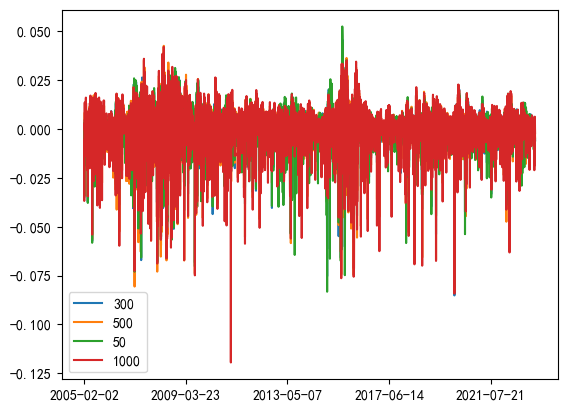

In [751]:
Risk.T.plot()

In [700]:
def UMR(x,m=60,h=30):
    ws = []
    
    sum_buttom = sum([2**(-i/h) for i in range(len(x))])
    for j in range(len(x)):
        ws.append((2**(-(m-j+1)/h))/sum_buttom)
    
    # display(sum_buttom,sum(ws[:]))
    return np.nansum(np.array(ws) * x)

In [701]:
ART_UMR = f.T.shift(1).rolling(60).apply(UMR).T.loc[['50', '300', '500', '1000'],'2016-02-28':]

In [702]:
risk_qt = Risk.rolling(5000,min_periods=1).apply(lambda x :x.rank(ascending=False)[-1]/len(x))

In [752]:
Risk

2005-02-02  2005-02-03  2005-02-04  2005-02-16  2005-02-17  2005-02-18  \
300     0.002542   -0.035078   -0.004976   -0.012946    0.002335    0.004769   
500    -0.000690   -0.034353   -0.004051   -0.000099    0.003401    0.007974   
50      0.001436   -0.034323   -0.007159   -0.018800    0.003259    0.001367   
1000   -0.005713   -0.036842   -0.004587    0.002644   -0.000294    0.007602   

      2005-02-21  2005-02-22  2005-02-23  2005-02-24  ...  2023-04-24  \
300     0.003220   -0.000040   -0.003380    0.007439  ...   -0.011832   
500     0.008405    0.003994   -0.005800    0.002397  ...   -0.017409   
50      0.001550   -0.000777   -0.001462    0.003914  ...   -0.010231   
1000    0.013562    0.003901   -0.008211   -0.002170  ...   -0.019001   

      2023-04-25  2023-04-26  2023-04-27  2023-04-28  2023-05-04  2023-05-05  \
300    -0.007575   -0.007238   -0.000536   -0.004149   -0.000068    0.001585   
500    -0.003014   -0.017632   -0.003394   -0.000484   -0.004260    0.003651   
50     -0.007239   -0.002123    0.002113   -0.006577   -0.001178   -0.004709   
1000   -0.002007   -0.021102   -0.002656   -0.000227   -0.004102    0.006274   

      2023-05-08  2023-05-09  2023-05-10  
300    -0.001946   -0.002886   -0.005739  
500    -0.003628    0.001408   -0.004674  
50     -0.001414   -0.003997   -0.005909  
1000   -0.006295    0.003121   -0.002110  

[4 rows x 4436 columns]

0.12012738851829957
1 0.9017749092375958
2 0.9019766034691408
3 0.9019766034691408
4 0.9507866075030255


<Axes: >

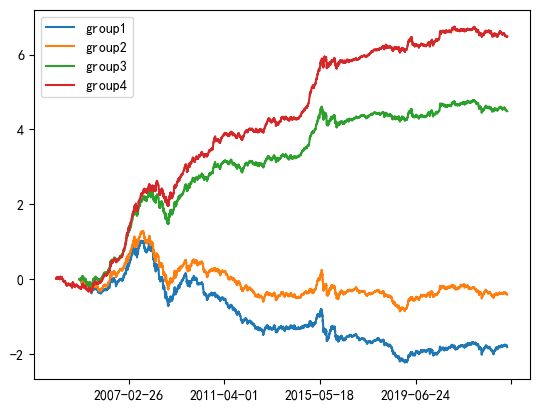

In [1634]:
# 分组收益率
xy.cal_rate_group(
    # Risk.loc[['50', '300', '500', '1000'],'2016-02-28':],
    (xy.Index_rets).T.rolling(20,min_periods=1).apply(lambda x:x[-1] - x.mean()).T.loc[['50', '300', '500', '1000'],:].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    # ART_UMR.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],:],
    group_num=4,
    masks=1
)[:].cumsum().plot()

In [1852]:
(DNexR - DN.T.rolling(20).mean().T.loc[['50', '300', '500', '1000'],:]).T.dropna().T

2005-01-31  2005-02-01  2005-02-02  2005-02-03  2005-02-04  2005-02-16  \
50      0.014454    0.008790   -0.006864    0.003219    0.003432   -0.008630   
300     0.009204    0.006126   -0.003514    0.002027    0.000078   -0.004059   
500    -0.004735   -0.001104    0.002776   -0.001735   -0.002545    0.004032   
1000   -0.010093   -0.006468    0.006966   -0.003048   -0.004353    0.006901   

      2005-02-17  2005-02-18  2005-02-21  2005-02-22  ...  2023-04-24  \
50     -0.010731   -0.004307   -0.002332   -0.012959  ...   -0.002646   
300    -0.005854   -0.001849   -0.002140   -0.006517  ...   -0.001799   
500     0.006240    0.002037   -0.000515    0.002317  ...    0.003441   
1000    0.009151    0.005417    0.002860    0.008288  ...    0.004099   

      2023-04-25  2023-04-26  2023-04-27  2023-04-28  2023-05-04  2023-05-05  \
50      0.009586   -0.002380    0.004114   -0.002858    0.003757    0.001515   
300     0.004129   -0.001873    0.001839   -0.003499   -0.002799    0.003538   
500    -0.003803    0.003756   -0.003106    0.002022   -0.000493   -0.001143   
1000   -0.005250    0.003207   -0.002574    0.003267   -0.002002   -0.002572   

      2023-05-08  2023-05-09  2023-05-10  
50      0.000850    0.002172   -0.006559  
300     0.000526    0.000950   -0.001851  
500    -0.000203    0.001020    0.004748  
1000   -0.001214   -0.001482    0.008195  

[4 rows x 4438 columns]

0.03474500878336792
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

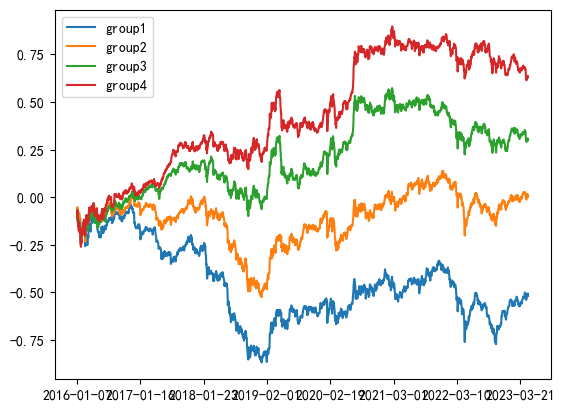

In [2370]:
# 分组收益率
xy.cal_rate_group(
    # Risk.loc[['50', '300', '500', '1000'],'2016-02-28':],
    # (DNexR).T.rolling(1,min_periods=1).apply(lambda x:x[-1] ).T.loc[['50', '300', '500', '1000'],:].shift(1,axis=1),
    (DNexR - DN.T.rolling(20).mean().T.loc[['50', '300', '500', '1000'],'2016-01-07':]).T.dropna().T.shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    # ART_UMR.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-01-07':],
    group_num=4,
    masks=1
)[:].cumsum().plot()

In [ ]:
# 分组收益率
xy.cal_rate_group(
    # Risk.loc[['50', '300', '500', '1000'],'2016-02-28':],
    (DNexR).T.rolling(12,min_periods=1).apply(lambda x:x.mean()).T.loc[['50', '300', '500', '1000'],:].shift(1,axis=1),
    # (xy.index_tov/xy.index_tov.shift(axis=1)).T.rolling(5).mean().T.shift(1,axis=1).loc[['50', '300', '500', '1000'],'2016-02-28':],
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    # ART_UMR.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2006-02-28':],
    group_num=4,
    masks=1
)[:].cumsum().plot()

0.05385132718763886
1 0.990550305725403
2 0.990550305725403
3 0.990550305725403
4 0.990550305725403


<Axes: >

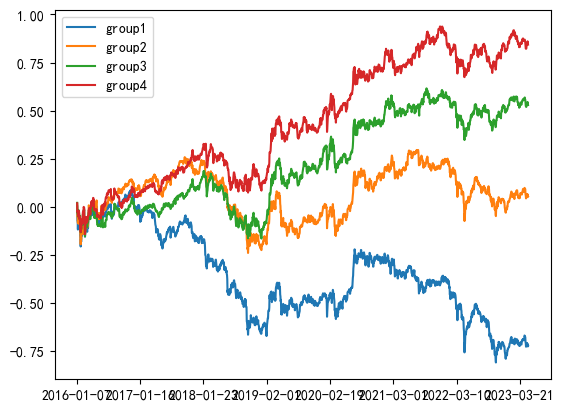

In [2374]:
# 分组收益率
xy.cal_rate_group(
    # Risk.loc[['50', '300', '500', '1000'],'2016-02-28':],
    ((xy.index_tov/xy.index_tov.shift(axis=1)).shift(1,axis=1)*(exR).T.rolling(12,min_periods=1).apply(lambda x:x.mean()).T.loc[:,'2016-01-07':].shift(1,axis=1)).loc[:,'2016-01-07':],
    # (xy.index_tov/xy.index_tov.shift(axis=1)).T.rolling(5).mean().T.shift(1,axis=1).loc[['50', '300', '500', '1000'],'2016-02-28':],
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    # ART_UMR.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2006-02-28':],
    group_num=4,
    masks=1
)[:].cumsum().plot()

774.0
yoy: 0.23411054685965998 
 mdd: -0.14810322294931166 
 sharpe: 1.1773155727561164 
 rankIC: 0.031145717463848723 
 rankIR: 0.031152168383068883 
 win%: 0.5155728587319244 
 gain_loss%: -1.14589438596277


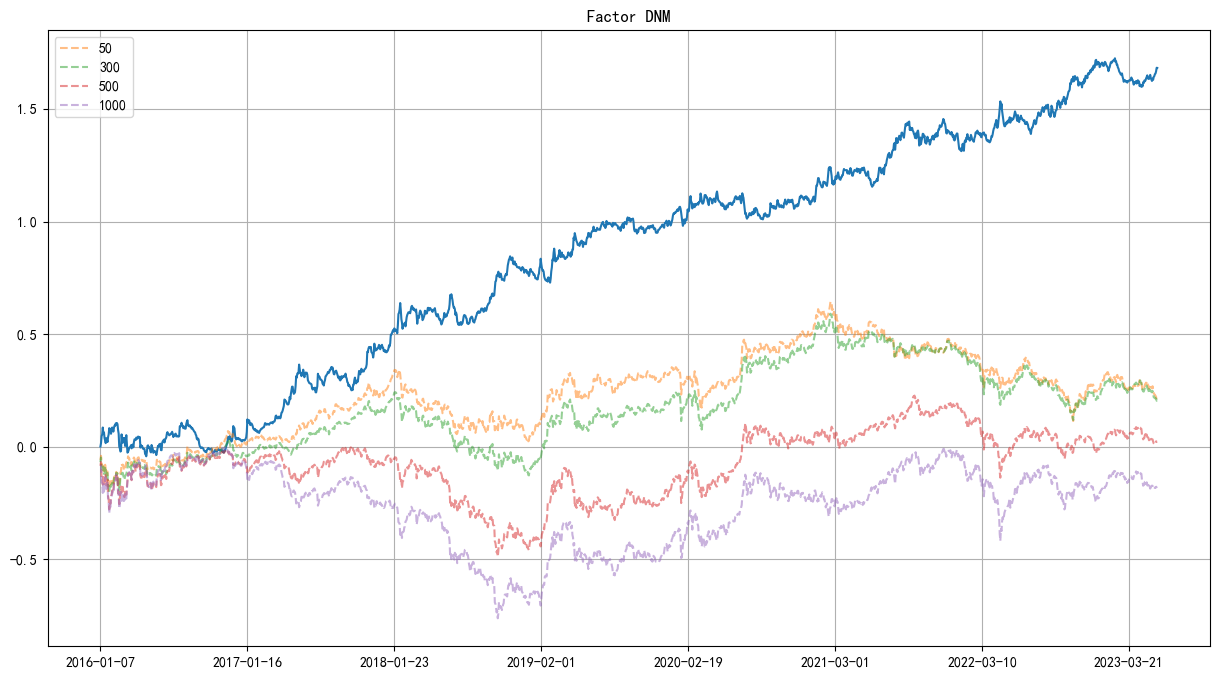

In [2378]:
# 单因子强弱
DNM_select1, DNM_rets1 = xy.single_Factor_backtest(
    # (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2017-01-07':].shift(1,axis=1),
    # (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()).T.loc[['50', '300', '500', '1000'],:].shift(1,axis=1),
    ((exR).T.rolling(12,min_periods=1).apply(lambda x:x.mean()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1)).loc[['50',  '1000'],'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-01-07':],
    _side=1,
    fee=0.00,
    name='DNM'
)

In [2409]:
TR300 = pd.concat([
    (xy.index_high.T['300'] - xy.index_low.T['300']).abs()/xy.cl.T['300'],
    (xy.index_high.T['300'] - xy.cl.T['300'].shift(1)).abs()/xy.cl.T['300'],
    (xy.cl.T['300'].shift(1) - xy.index_low.T['300']).abs()/xy.cl.T['300']
],axis=1).dropna().max(axis=1).rename('300')
TR50 = pd.concat([
    (xy.index_high.T['50'] - xy.index_low.T['50']).abs()/xy.cl.T['50'],
    (xy.index_high.T['50'] - xy.cl.T['50'].shift(1)).abs()/xy.cl.T['50'],
    (xy.cl.T['50'].shift(1) - xy.index_low.T['50']).abs()/xy.cl.T['50']
],axis=1).dropna().max(axis=1).rename('50')
TR500 = pd.concat([
    (xy.index_high.T['500'] - xy.index_low.T['500']).abs()/xy.cl.T['500'],
    (xy.index_high.T['500'] - xy.cl.T['500'].shift(1)).abs()/xy.cl.T['500'],
    (xy.cl.T['500'].shift(1) - xy.index_low.T['500']).abs()/xy.cl.T['500']
],axis=1).dropna().max(axis=1).rename('500')
TR1000 = pd.concat([
    (xy.index_high.T['1000'] - xy.index_low.T['1000']).abs()/xy.cl.T['1000'],
    (xy.index_high.T['1000'] - xy.cl.T['1000'].shift(1)).abs()/xy.cl.T['1000'],
    (xy.cl.T['1000'].shift(1) - xy.index_low.T['1000']).abs()/xy.cl.T['1000']
],axis=1).dropna().max(axis=1).rename('1000')
# ATR300 = TR.rolling(15).mean().dropna()

ATR = pd.concat([
    TR50,
    # TR300,
    # TR500,
    TR1000
],axis=1).rolling(60).mean().T

In [2411]:
adj_ATR = ATR.mean().dropna().map(lambda x: (x/0.01)**0.5 if x < 0.01 else ((x/0.02)**0.5 if x > 0.02 else 1))

In [2619]:
ATR.T.dropna()

50      1000
2005-04-07  0.017817  0.022462
2005-04-08  0.017937  0.022368
2005-04-11  0.017956  0.022418
2005-04-12  0.017948  0.022560
2005-04-13  0.018174  0.022729
...              ...       ...
2023-05-04  0.012376  0.011870
2023-05-05  0.012235  0.011994
2023-05-08  0.012362  0.012000
2023-05-09  0.012477  0.012096
2023-05-10  0.012451  0.011922

[4397 rows x 2 columns]

In [2629]:
high_increasing = (xy.index_high/xy.cl.shift(1,axis=1) - 1).loc[['50','1000']].T.dropna().mean(axis=1)
low_increasing = (xy.index_low/xy.cl.shift(1,axis=1) - 1).loc[['50','1000']].T.dropna().mean(axis=1)

In [2634]:
Y = pd.concat([
    (xy.Index_rets).loc[['50','1000']].T.dropna().mean(axis=1).rename('cl-cl'),
    high_increasing.rename('high_increasing'),
    low_increasing.rename('low_increasing')
],axis=1).dropna()

In [ ]:
def cal_break(x):
    if (x[-1]>0.01):
        if ((max(x[-6:-1])-min(x[-6:-1]))<0.01):
            (x.rolling(5).max()[-2] - x.rolling(5).min()[-2] >x.rolling(5).max()[-1] - x.rolling(5).min()[-1])) else np.nan

In [2623]:
(xy.Index_rets).loc[['50','1000']].T.dropna().mean(axis=1).rolling(11).apply(lambda x:).dropna()

Series([], dtype: float64)

In [2441]:
atr300 = pd.concat([
    (xy.Index_rets).loc[['50','1000'],adj_ATR.index].mean().rename('300'),
    adj_ATR.rename('ATR')
],axis=1).sort_index().dropna()

In [2586]:
atr300['shrd_down'] = -0.05 * atr300['ATR']
atr300['shrd_up'] = 0.005 * atr300['ATR']

In [2587]:
atr300['mdd20'] = atr300['300'].rolling(10).apply(lambda x:x[:-1].sum())#

In [ ]:
CN_Index_cumret = xy.Index_rets.loc[[ '300'],same_dates].T.loc['2010-01-04':]
CN_Index_cumret['Bondgap'] = Bondgap.loc[same_dates].diff().loc['2010-01-04':][::5]#rolling(120).apply(lambda x:x.rank()[-1]/120).loc['2017-01-04':]
CN_Index_cumret['Bond10'] = BondCN10yield.loc[same_dates].diff().loc['2010-01-04':][::5]
CN_Index_cumret['Bond1'] = BondCN1yield.loc[same_dates].diff().loc['2010-01-04':][::5]

In [ ]:
CN_Index_cumret

300  Bondgap  Bond10   Bond1
2010-01-04 -0.011314   0.0181  0.0314  0.0133
2010-01-11 -0.010762   0.0271  0.0373  0.0102
2010-01-18 -0.005609   0.0206  0.0336  0.0130
2010-01-25 -0.016952   0.0065  0.0195  0.0130
2010-02-01 -0.033009  -0.0272 -0.0135  0.0137
...              ...      ...     ...     ...
2023-04-27  1.089750  -0.2693  0.1832  0.4525
2023-05-09  1.081188  -0.2687  0.1808  0.4495
2023-05-16  1.076016  -0.2762  0.1837  0.4599
2023-05-23  1.061873  -0.2465  0.1664  0.4129
2023-05-30  1.062867  -0.2385  0.1609  0.3994

[652 rows x 4 columns]

In [ ]:
CN_Index_cumret['Bond10'].diff().shift(1).corr(CN_Index_cumret['300'].diff())

0.017523012154161653

<Axes: >

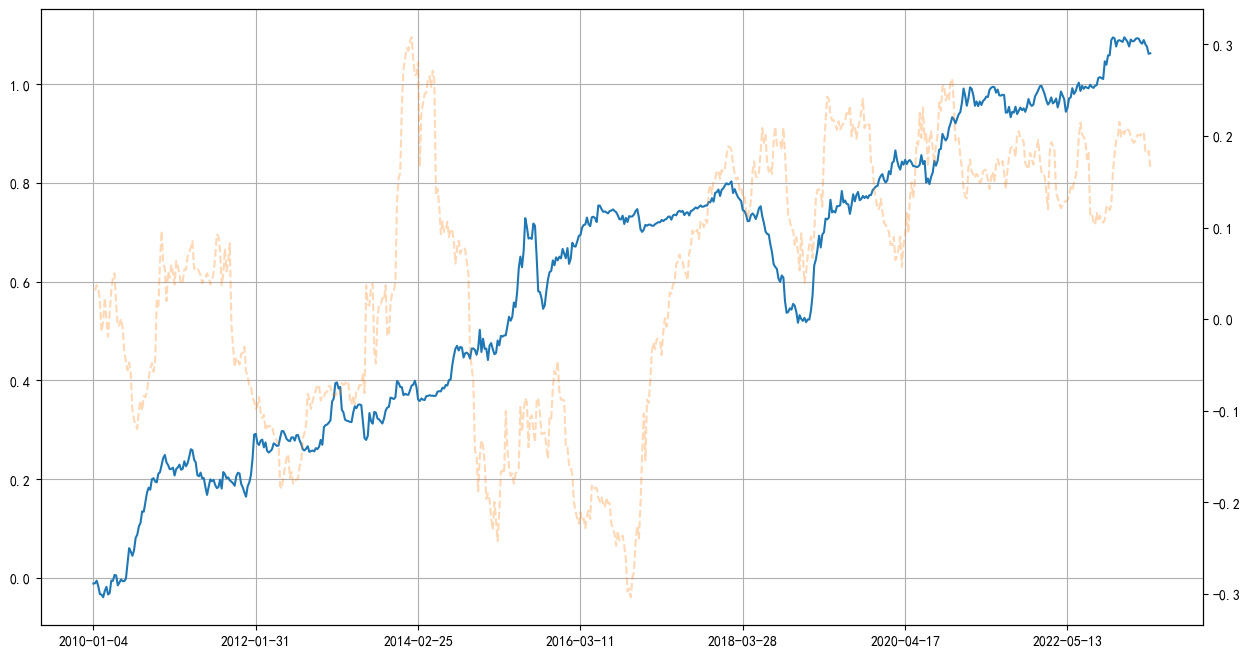

In [2820]:
# BondCN10yield.loc[same_dates].plot()
CN_Index_cumret['300'].plot(figsize=(15,8),grid=True)
# CN_Index_cumret['Bondgap'].plot(figsize=(15,8),secondary_y=True)
CN_Index_cumret['Bond10'].shift(1).plot(figsize=(15,8),secondary_y=True,style='--',alpha=0.3)
# CN_Index_cumret['Bond1'].plot(figsize=(15,8),secondary_y=True,style='--',alpha=0.3)

<Axes: >

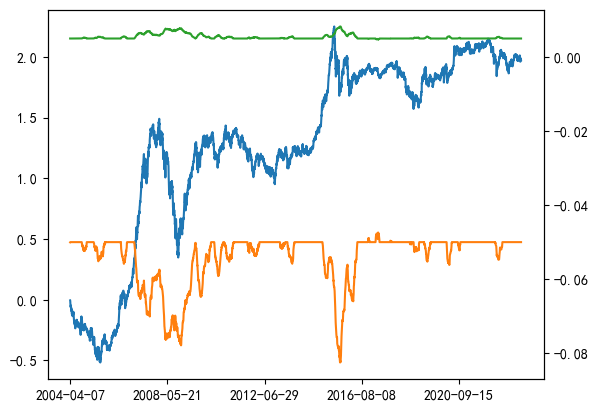

In [2589]:
atr300['300'].cumsum().plot()
atr300['shrd_down'].plot(secondary_y=True)
atr300['shrd_up'].plot(secondary_y=True)

In [2590]:
rebound_dates = atr300.dropna()[(atr300.dropna()['300'] >= atr300.dropna()['shrd_up']) & (atr300.dropna()['mdd20'] < atr300.dropna()['shrd_down'])].index

In [2591]:
len(rebound_dates)

197

In [2630]:
xxx50 = pd.Series((DNexR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()).T.loc[['50','1000'],'2004-01-04':].shift(1,axis=1).loc[:,(DNexR).T[(DNexR).T.index.isin(rebound_dates[:])].dropna().cumsum().index].loc['50'],index = DNexR.columns).rename('50')
xxx1000 = pd.Series((DNexR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()).T.loc[['50','1000'],'2004-01-04':].shift(1,axis=1).loc[:,(DNexR).T[(DNexR).T.index.isin(rebound_dates[:])].dropna().cumsum().index].loc['1000'],index = DNexR.columns).rename('1000')

<Axes: >

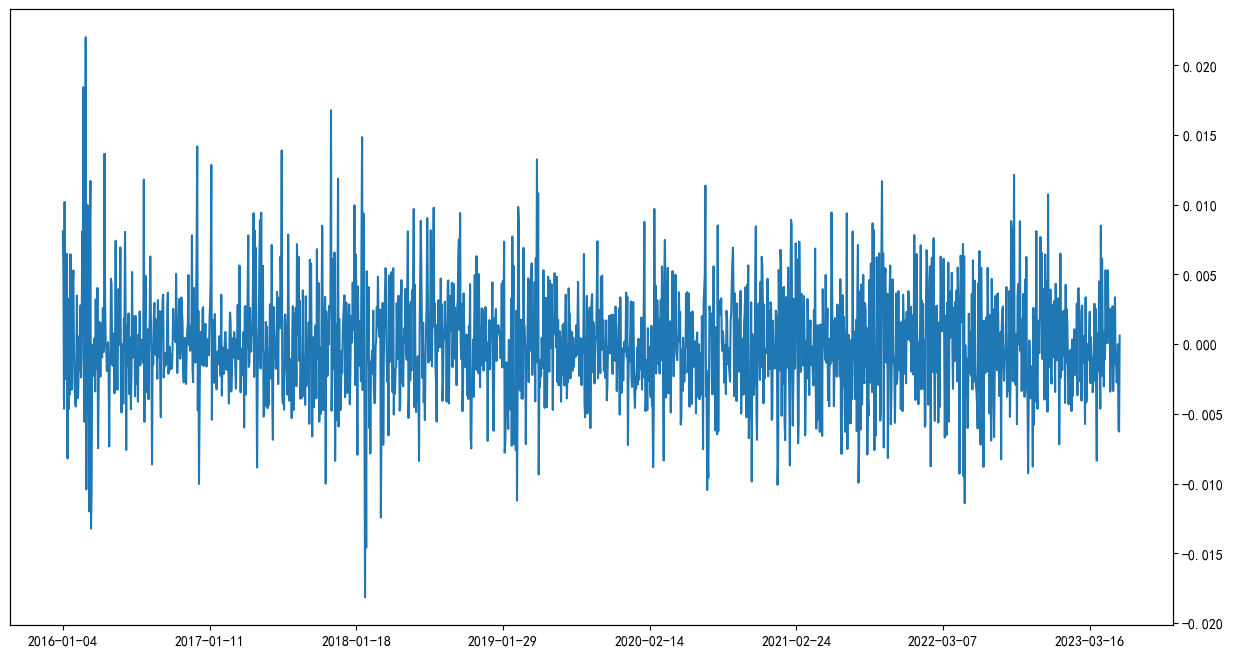

In [2674]:
# (xy.Index_rets.loc['50','2016-01-04':].rename('50') - xy.Index_rets.loc['300','2016-01-04':].rename('300')).dropna().rolling(240).apply(lambda x: (x[-1] - x.mean())/x.std())[:].dropna().plot(figsize=(15,8))
(xy.Index_rets.loc['50','2016-01-04':].rename('50') - xy.Index_rets.loc['300','2016-01-04':].rename('300')).dropna()[:].dropna().plot(figsize=(15,8),secondary_y=True)

778.0
yoy: 0.20759097702805349 
 mdd: -0.28887055431807407 
 sharpe: 1.040869266285171 
 rankIC: 0.03928170594837262 
 rankIR: 0.039301016068725325 
 win%: 0.5196408529741863 
 gain_loss%: -1.1017822693046622


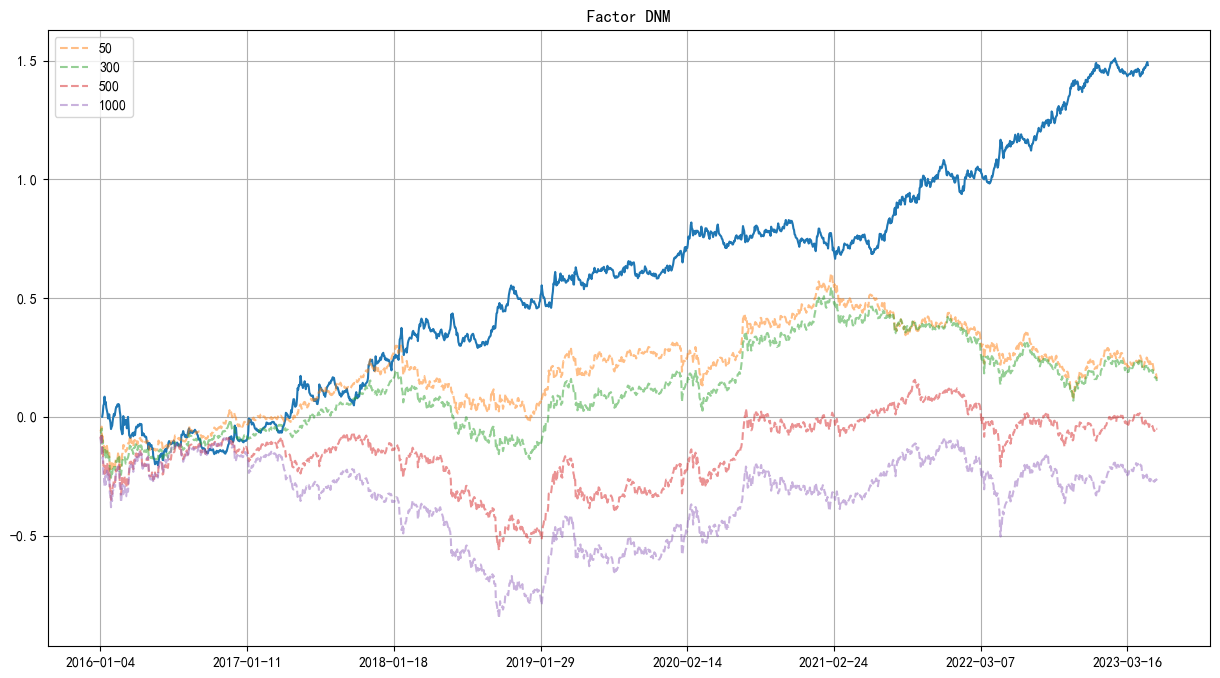

In [2667]:
# new_high_count = xy.cl.loc[['50','300', '500',  '1000'],'2006-01-04':'2012-01-23'].T.rolling(120).apply(lambda x:1 if x[-1]>x[:-1].max() else 0).T.sum()

# new_high_count_cp = new_high_count.copy()
# new_high_count_cp.loc[new_high_count[new_high_count.diff()>0].index] = 0
# new_high_count_cp.loc[new_high_count[(new_high_count.diff()<0)].index] = 1
# new_high_count_cp.loc[new_high_count[(new_high_count.diff()==0)].index] = 0

# 单因子强弱
DNM_select2, DNM_rets2 = xy.single_Factor_backtest(
    # (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2017-01-07':].shift(1,axis=1),
    (DNexR).T.rolling(12,min_periods=1).apply(lambda x:x.mean()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # (DNexR).T.rolling(60,min_periods=1).apply(lambda x:x[-1] - x.mean()).T.loc[['50','1000'],'2004-01-04':].shift(1,axis=1),
    
    #     pd.concat([
    #     xxx50,
    #     xxx1000,
    # ],axis=1).shift(0).T.loc[['50','1000'],'2004-01-04':],
    
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500','1000'],'2016-01-04':],
    _side=1,
    fee=0.00,
    name='DNM'
)
# xy.cl.loc[:,'2005-02-28':].T.rolling(60).apply(lambda x:1 if x[-1]==x.max() else 0).T.sum().plot(figsize=(15,8),grid=True)
# new_high_count_cp.rolling(10).sum()['2006-01-04':'2012-01-23'].plot(figsize=(15,8),secondary_y=True)
# (ATR.mean()/10)['2006-02-23':].plot(secondary_y=True)
# (((xy.cl.loc[['50','300', '500',  '1000'],'2006-01-04':'2012-01-23'].T.diff().T).sum() - ATR.mean()['2006-01-04':'2012-01-23'])/20).rolling(120).mean().plot(figsize=(15,8),secondary_y=True)

2522.0
yoy: 0.9143790417720457 
 mdd: -0.1848193414348942 
 sharpe: 4.001435389019025 
 rankIC: 0.18286879673691367 
 rankIR: 0.1859421092205074 
 win%: 0.5914343983684568 
 gain_loss%: -1.3671628689721322


<Axes: >

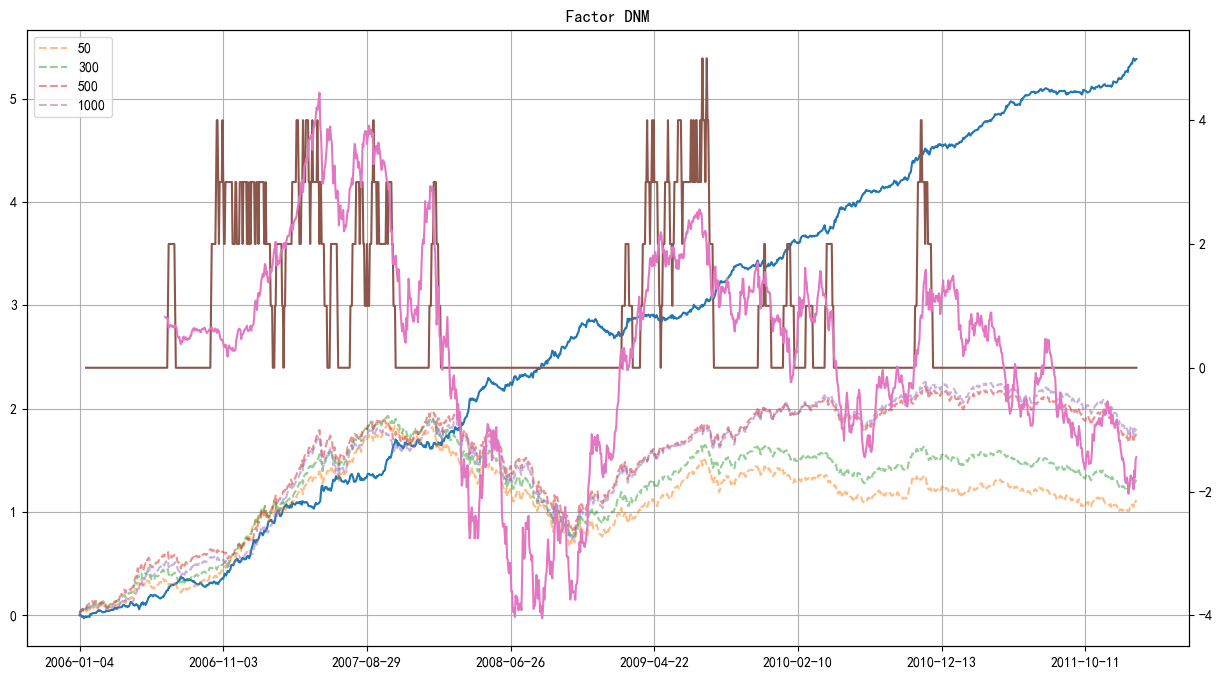

In [2560]:
new_high_count = xy.cl.loc[['50','300', '500',  '1000'],'2006-01-04':'2012-01-23'].T.rolling(120).apply(lambda x:1 if x[-1]>x[:-1].max() else 0).T.sum()

new_high_count_cp = new_high_count.copy()
new_high_count_cp.loc[new_high_count[new_high_count.diff()>0].index] = 0
new_high_count_cp.loc[new_high_count[(new_high_count.diff()<0)].index] = 1
new_high_count_cp.loc[new_high_count[(new_high_count.diff()==0)].index] = 0

# 单因子强弱
DNM_select2, DNM_rets2 = xy.single_Factor_backtest(
    # (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2017-01-07':].shift(1,axis=1),
    # (DNexR).T.rolling(12,min_periods=1).apply(lambda x:x.mean()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    (DNexR).T.rolling(60,min_periods=1).apply(lambda x:x[-1] - x.mean()).T.loc[['50','1000'],'2006-01-04':'2012-01-23'].shift(1,axis=1),
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500','1000'],'2006-01-04':'2012-01-23'],
    _side=1,
    fee=0.00,
    name='DNM'
)
# xy.cl.loc[:,'2005-02-28':].T.rolling(60).apply(lambda x:1 if x[-1]==x.max() else 0).T.sum().plot(figsize=(15,8),grid=True)
new_high_count_cp.rolling(10).sum()['2006-01-04':'2012-01-23'].plot(figsize=(15,8),secondary_y=True)
# (ATR.mean()/10)['2006-02-23':].plot(secondary_y=True)
(((xy.cl.loc[['50','300', '500',  '1000'],'2006-01-04':'2012-01-23'].T.diff().T).sum() - ATR.mean()['2006-01-04':'2012-01-23'])/20).rolling(120).mean().plot(figsize=(15,8),secondary_y=True)

3094.0
yoy: 0.47455653599883985 
 mdd: -0.32558741054628615 
 sharpe: 1.8758445055622324 
 rankIC: 0.10324483775811209 
 rankIR: 0.10376892153880402 
 win%: 0.5512971698113207 
 gain_loss%: -1.144176559933327


<Axes: >

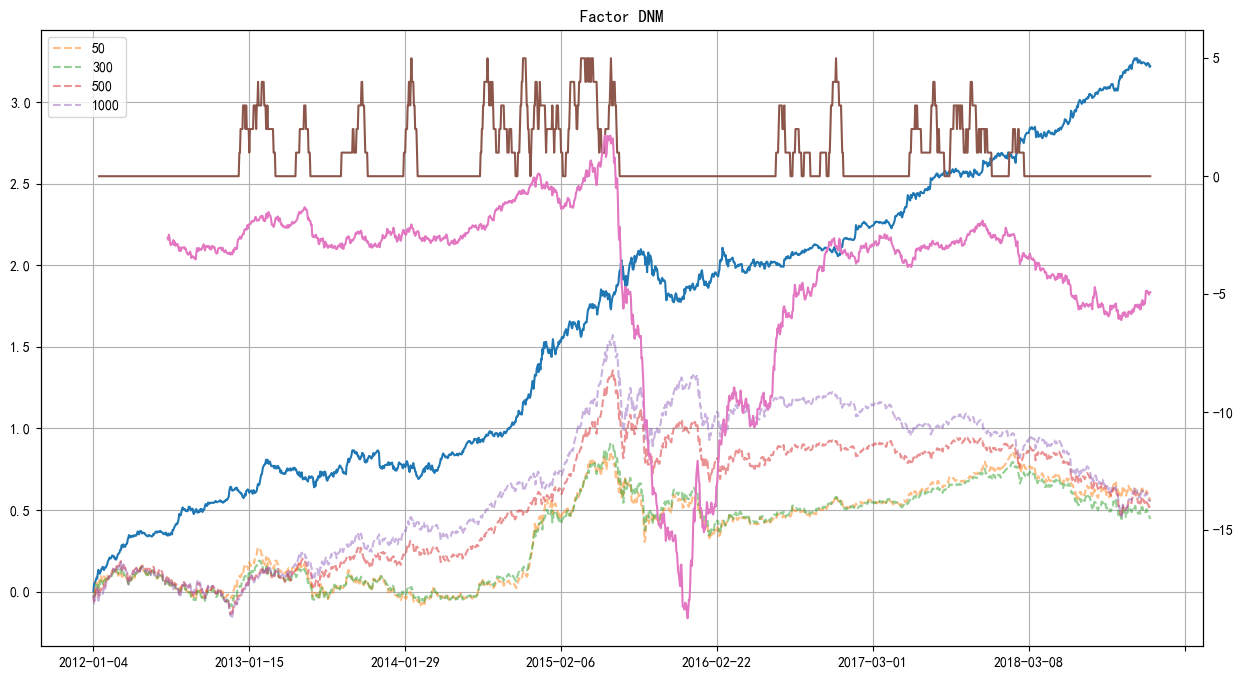

In [1838]:
new_high_count = xy.cl.loc[['50','300', '500',  '1000'],'2012-01-04':'2018-12-23'].T.rolling(120).apply(lambda x:1 if x[-1]>x[:-1].max() else 0).T.sum()

new_high_count_cp = new_high_count.copy()
new_high_count_cp.loc[new_high_count[new_high_count.diff()>0].index] = 0
new_high_count_cp.loc[new_high_count[(new_high_count.diff()<0)].index] = 1
new_high_count_cp.loc[new_high_count[(new_high_count.diff()==0)].index] = 0

# 单因子强弱
DNM_select2, DNM_rets2 = xy.single_Factor_backtest(
    # (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2017-01-07':].shift(1,axis=1),
    # (DNexR).T.rolling(12,min_periods=1).apply(lambda x:x.mean()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    (DNexR).T.rolling(60,min_periods=1).apply(lambda x:x[-1] - x.mean()).T.loc[['50','1000'],'2012-01-04':'2018-12-23'].shift(1,axis=1),
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500','1000'],'2012-01-04':'2018-12-23'],
    _side=1,
    fee=0.00,
    name='DNM'
)
# xy.cl.loc[:,'2005-02-28':].T.rolling(60).apply(lambda x:1 if x[-1]==x.max() else 0).T.sum().plot(figsize=(15,8),grid=True)
new_high_count_cp.rolling(10).sum()['2012-01-04':'2018-12-23'].plot(figsize=(15,8),secondary_y=True)
# (ATR.mean()/10)['2006-02-23':].plot(secondary_y=True)
(((xy.cl.loc[['50','300', '500',  '1000'],'2012-01-04':'2018-12-23'].T.diff().T).sum() - ATR.mean()['2012-01-04':'2018-12-23'])/20).rolling(120).mean().plot(figsize=(15,8),secondary_y=True)

3224.0
yoy: 0.05632008884730978 
 mdd: -0.26464773545663556 
 sharpe: 0.3582506813943946 
 rankIC: -0.0011331444759206783 
 rankIR: -0.0015691105717769516 
 win%: 0.4966949952785647 
 gain_loss%: -1.0769426773371154


<Axes: >

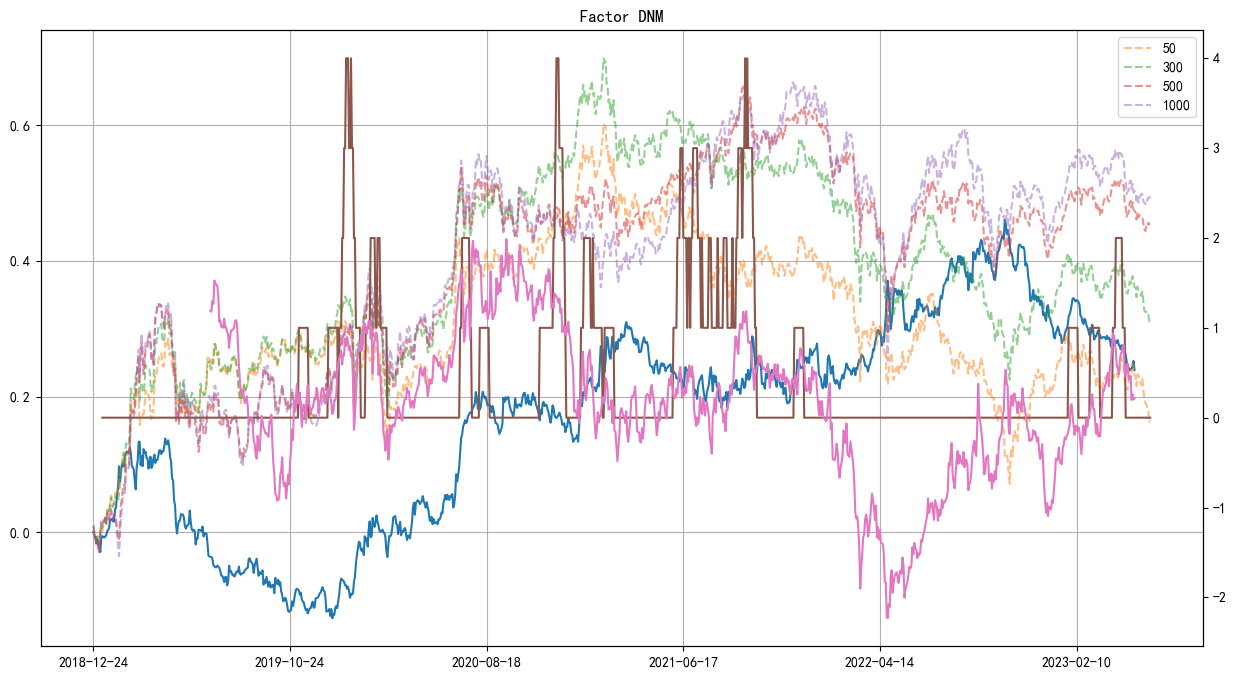

In [2609]:
new_high_count = xy.cl.loc[['50','300', '500',  '1000'],'2018-12-23':].T.rolling(120).apply(lambda x:1 if x[-1]>x[:-1].max() else 0).T.sum()

new_high_count_cp = new_high_count.copy()
new_high_count_cp.loc[new_high_count[new_high_count.diff()>0].index] = 0
new_high_count_cp.loc[new_high_count[(new_high_count.diff()<0)].index] = 1
new_high_count_cp.loc[new_high_count[(new_high_count.diff()==0)].index] = 0


# 单因子强弱
DNM_select2, DNM_rets2 = xy.single_Factor_backtest(
    # (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2017-01-07':].shift(1,axis=1),
    # (DNexR).T.rolling(12,min_periods=1).apply(lambda x:x.mean()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    (DNexR).T.rolling(60,min_periods=1).apply(lambda x:(x[-1] - x.mean())/x.std()).T.loc[['50','300', '500',  '1000'],'2018-12-23':].shift(1,axis=1),
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500','1000'],'2018-12-23':],
    _side=1,
    fee=0.00,
    name='DNM'
)
# xy.cl.loc[:,'2005-02-28':].T.rolling(60).apply(lambda x:1 if x[-1]==x.max() else 0).T.sum().plot(figsize=(15,8),grid=True)
new_high_count_cp.rolling(10).sum()['2018-12-23':].plot(figsize=(15,8),secondary_y=True)
# (ATR.mean()/10)['2006-02-23':].plot(secondary_y=True)
(((xy.cl.loc[['50','300', '500',  '1000'],'2018-12-23':].T.diff().T).sum() - ATR.mean()['2018-12-23':])/20).rolling(120).mean().plot(figsize=(15,8),secondary_y=True)

658.0
yoy: -0.0026057226184142052 
 mdd: -0.8117769368687741 
 sharpe: -0.01303696541280934 
 rankIC: -0.023569023569023562 
 rankIR: -0.023568956732995354 
 win%: 0.4879416713404375 
 gain_loss%: -1.0459746114131545


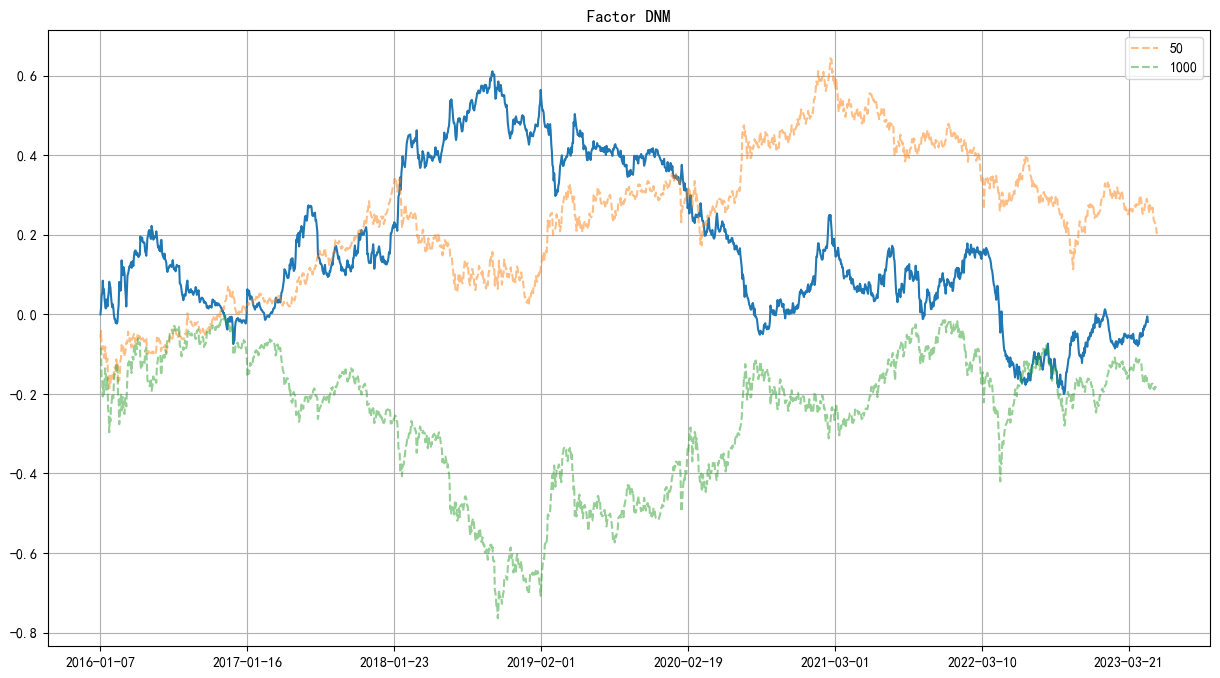

In [1736]:
# 单因子强弱
DNM_select3, DNM_rets3 = xy.single_Factor_backtest(
    # (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2017-01-07':].shift(1,axis=1),
    (ONexR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '1000'],'2016-01-07':],
    _side=1,
    fee=0.00,
    name='DNM'
)

<Axes: >

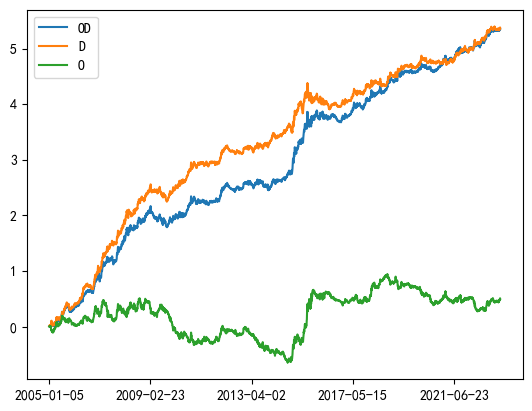

In [1527]:
pd.concat([
    DNM_rets1.rename('OD'),
    DNM_rets2.rename('D'),
    DNM_rets3.rename('O'),
],axis=1).dropna().cumsum().plot()

### Sharpe

1714.0
yoy: 0.2869054909148597 
 mdd: -0.36570143746013795 
 sharpe: 1.3121224435414687 
 rankIC: 0.06711409395973153 
 rankIR: 0.06725823301230936 
 win%: 0.48124243646631704 
 gain_loss%: -1.1112490583128931


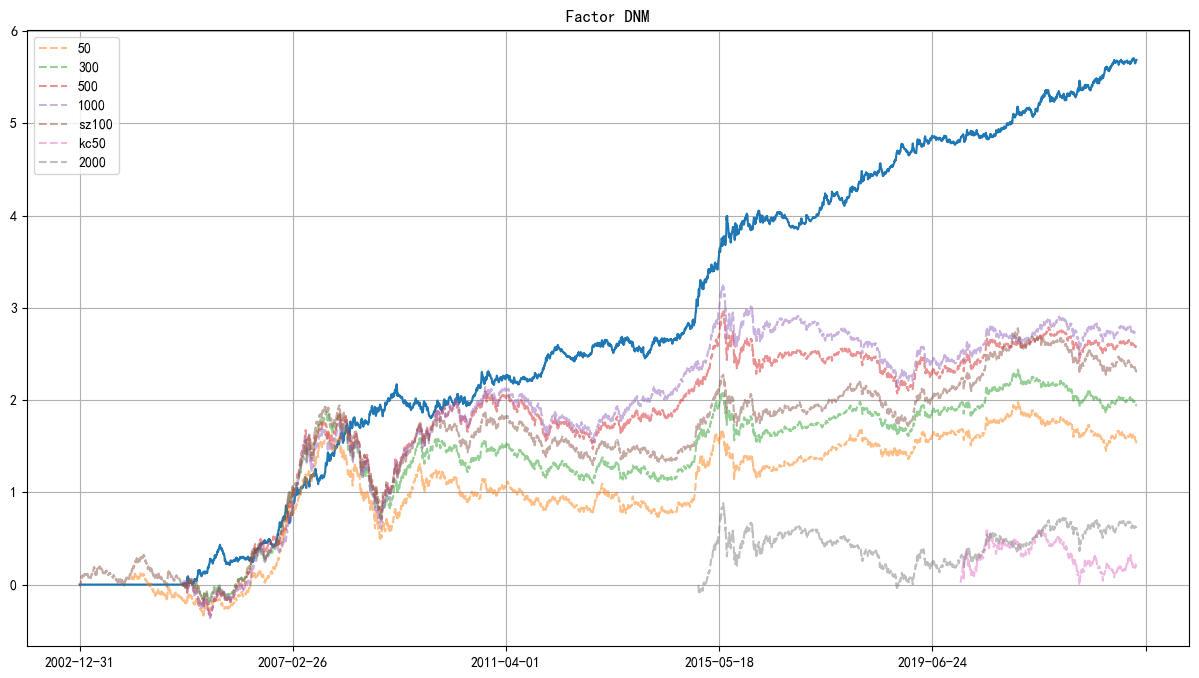

In [1534]:
# 单因子强弱
DNM_select11, DNM_rets11 = xy.single_Factor_backtest(
    (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],:].shift(1,axis=1),
    # xy.index_tov.pct_change(axis=1).shift(1,axis=1).loc[['50', '1000'],:],
    # xy.Index_rets.loc[:,:].T.rolling(13).apply(lambda x:x.mean()/x.std()).T.shift(1,axis=1).loc[['50', '300', '500', '1000'],:],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[:,:],
    _side=1,
    fee=0.00,
    name='DNM'
)

3182.0
yoy: 0.24056321238325046 
 mdd: -0.7294321310906637 
 sharpe: 1.156568464002269 
 rankIC: 0.06666872011936992 
 rankIR: 0.08639360182863776 
 win%: 0.5355620372447835 
 gain_loss%: -1.0594452401220735


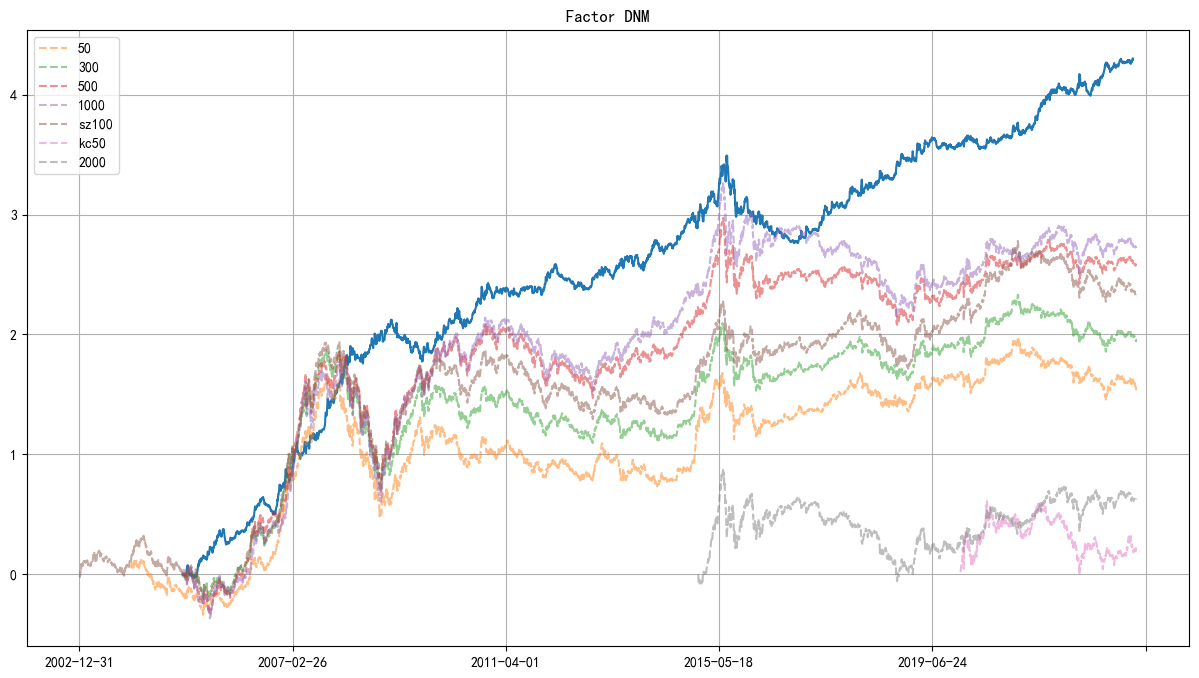

In [1539]:
# 单因子强弱
DNM_select22, DNM_rets22 = xy.single_Factor_backtest(
    (DN).T[['50', '300', '500', '1000']].dropna().rolling(13).apply(lambda x:x.mean()/x.std()).T.loc[['50', '300', '500', '1000'],:].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[:,:],
    _side=1,
    fee=0.00,
    name='DNM'
)

2684.0
yoy: 0.08527230942210702 
 mdd: -1.6547350780030547 
 sharpe: 0.42522900152021215 
 rankIC: -0.020383789380755198 
 rankIR: -0.027414341365673233 
 win%: 0.4872082585278277 
 gain_loss%: -1.1313174190920015


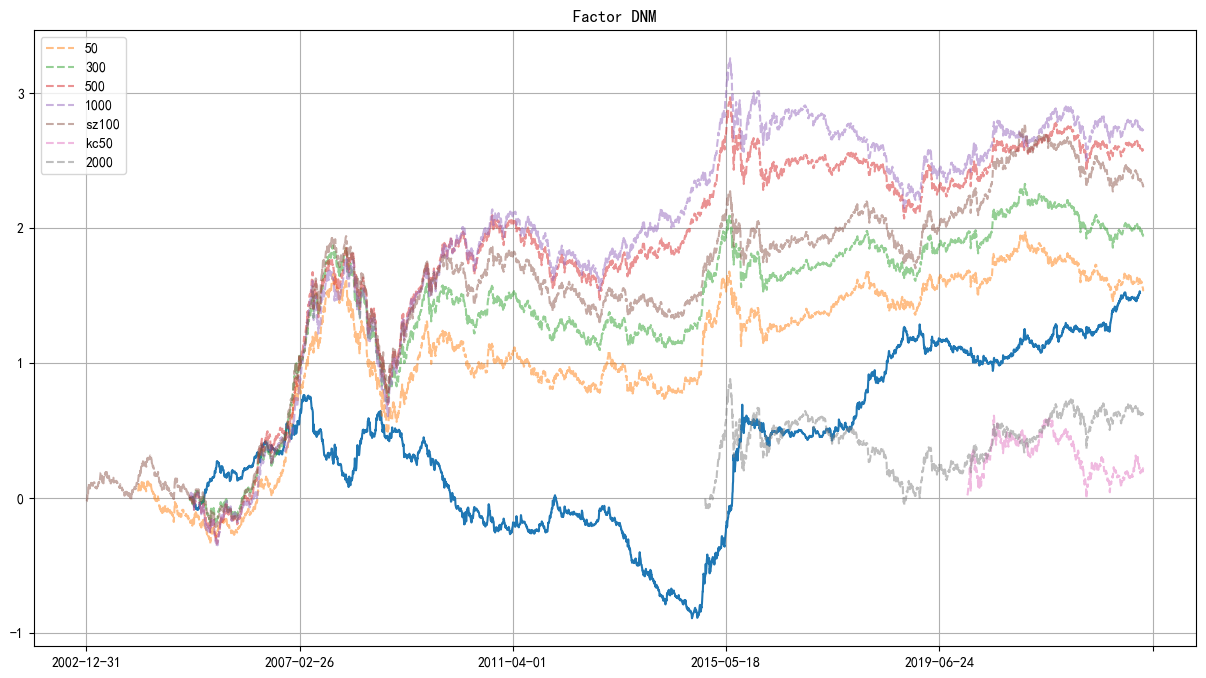

In [1530]:
# 单因子强弱
DNM_select33, DNM_rets33 = xy.single_Factor_backtest(
    (ON).T[['50', '300', '500', '1000']].dropna().rolling(13).apply(lambda x:x.mean()/x.std()).T.loc[['50', '300', '500', '1000'],:].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[:,:],
    _side=1,
    fee=0.00,
    name='DNM'
)

<Axes: >

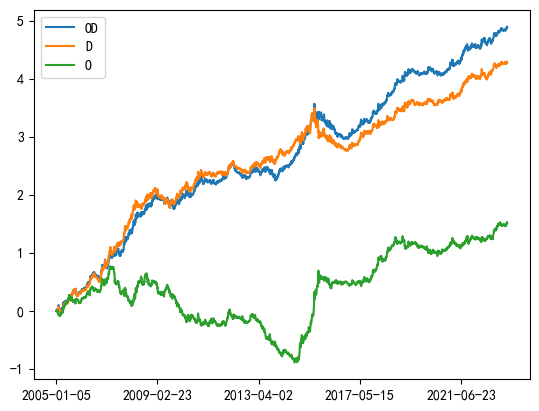

In [1480]:
pd.concat([
    DNM_rets11.rename('OD'),
    DNM_rets22.rename('D'),
    DNM_rets33.rename('O'),
],axis=1).dropna().cumsum().plot()

### 30日归一化动量

6486.0
yoy: 0.3779841740261326 
 mdd: -0.40306633975071904 
 sharpe: 1.4915346895330228 
 rankIC: 0.08838500694123091 
 rankIR: 0.08872200492111236 
 win%: 0.5347845601436265 
 gain_loss%: -1.1283007699367118


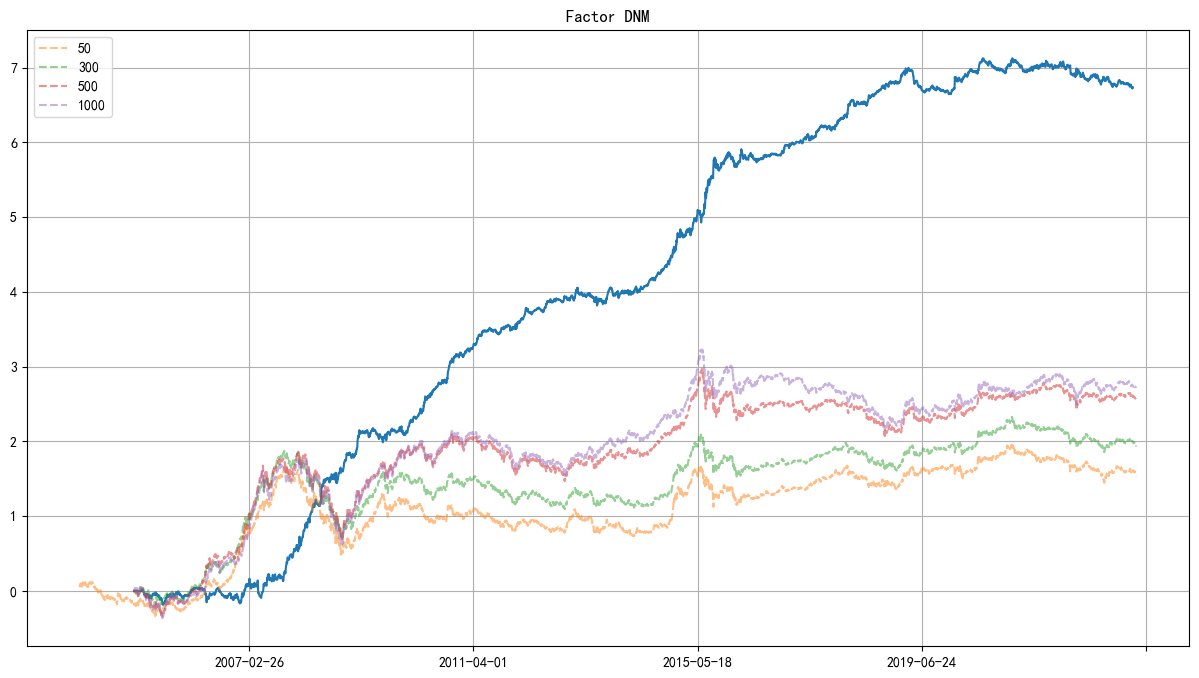

In [1468]:
# 单因子强弱
DNM_select111, DNM_rets111 = xy.single_Factor_backtest(
    ((DN+1)*(ON+1)-1).T[['50', '300', '500', '1000']].dropna().rolling(30).apply(lambda x:(x[-1]-x.min())/(x.max()-x.min())).T.loc[['50', '1000'],:].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],:],
    _side=1,
    fee=0.00,
    name='DNM'
)

10464.0
yoy: 0.2937084091575024 
 mdd: -0.6146353649811882 
 sharpe: 0.9256209755130389 
 rankIC: 0.0794607404908919 
 rankIR: 0.10444825871585542 
 win%: 0.5378056989006058 
 gain_loss%: -1.0511633629134833


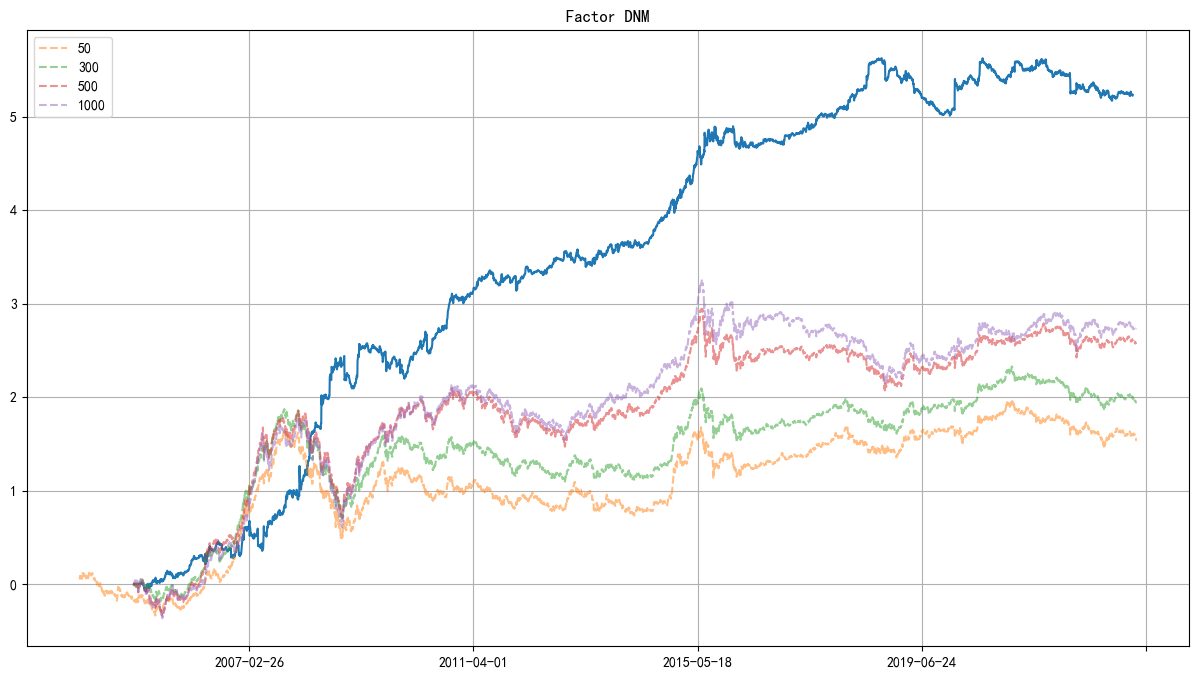

In [1472]:
# 单因子强弱
DNM_select222, DNM_rets222 = xy.single_Factor_backtest(
    ((DN)).T[['50', '300', '500', '1000']].dropna().rolling(30).apply(lambda x:(x[-1]-x.min())/(x.max()-x.min())).T.loc[['50', '300', '500', '1000'],:].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],:],
    _side=1,
    fee=0.00,
    name='DNM'
)

9728.0
yoy: -0.03582998376736685 
 mdd: -1.833115945139594 
 sharpe: -0.11073027840796502 
 rankIC: 0.013605145193451159 
 rankIR: 0.0185143457607147 
 win%: 0.4955116696588869 
 gain_loss%: -0.9781491695675292


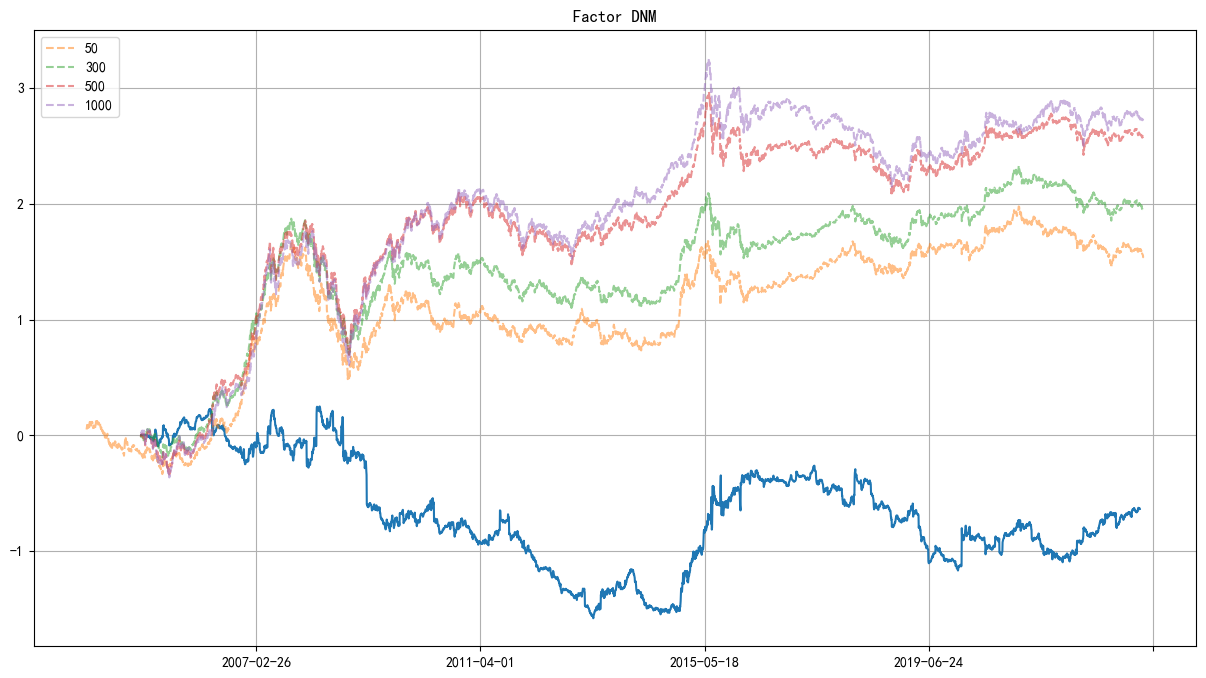

In [1473]:
# 单因子强弱
DNM_select333, DNM_rets333 = xy.single_Factor_backtest(
    ((ON)).T[['50', '300', '500', '1000']].dropna().rolling(30).apply(lambda x:(x[-1]-x.min())/(x.max()-x.min())).T.loc[['50', '300', '500', '1000'],:].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],:],
    _side=1,
    fee=0.00,
    name='DNM'
)

<Axes: >

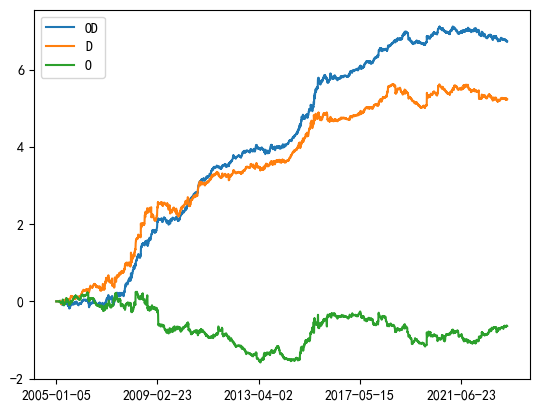

In [1474]:
pd.concat([
    DNM_rets111.rename('OD'),
    DNM_rets222.rename('D'),
    DNM_rets333.rename('O'),
],axis=1).dropna().cumsum().plot()

### ExR Singular

6770.0
yoy: 0.34614909216200374 
 mdd: -0.3861206934866148 
 sharpe: 1.5835660588288774 
 rankIC: 0.09095002251238178 
 rankIR: 0.09131825677042912 
 win%: 0.49213392496974584 
 gain_loss%: -1.112686660570028


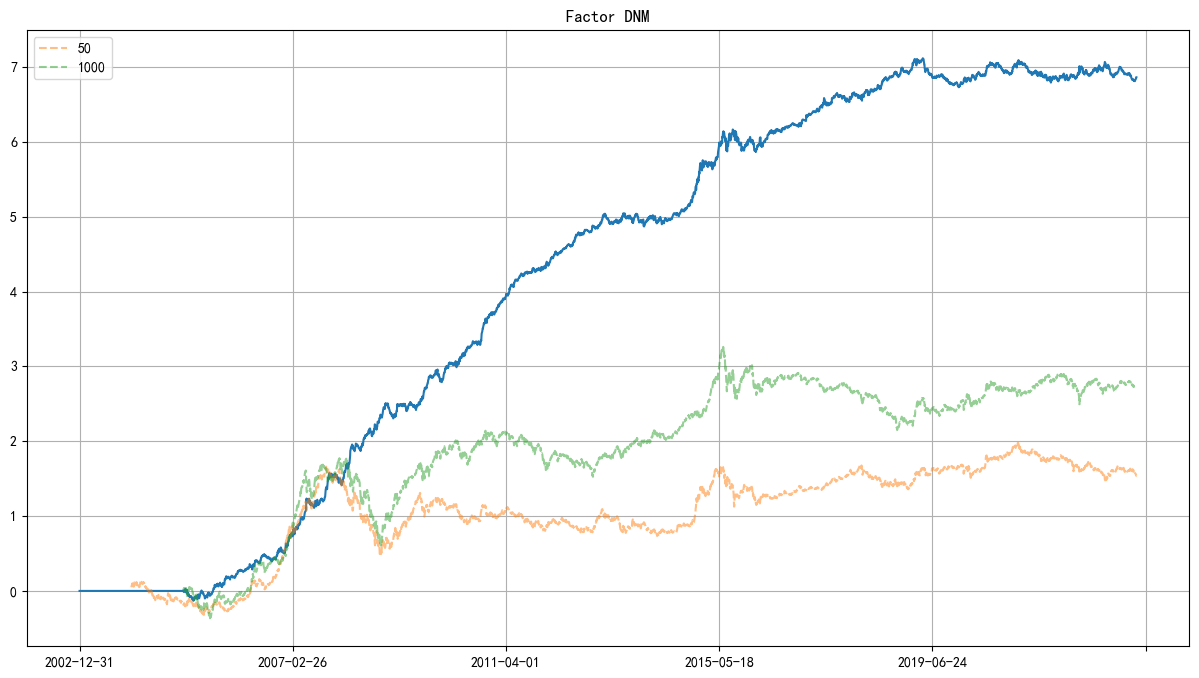

In [1520]:
# 单因子强弱
DNM_select1111, DNM_rets1111 = xy.single_Factor_backtest(
    # (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2017-01-07':].shift(1,axis=1),
    (exR).T.rolling(30).apply(lambda x:(x[-1]-x.min())/(x.max()-x.min())).T.loc[['50', '1000'],:].shift(1,axis=1),
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '1000'],:],
    _side=1,
    fee=0.00,
    name='DNM'
)

11450.0
yoy: 0.4021439034309918 
 mdd: -0.31856285419787866 
 sharpe: 2.015215093404824 
 rankIC: 0.08776106654434424 
 rankIR: 0.12043030721607953 
 win%: 0.5508189365043752 
 gain_loss%: -1.1663774862884897


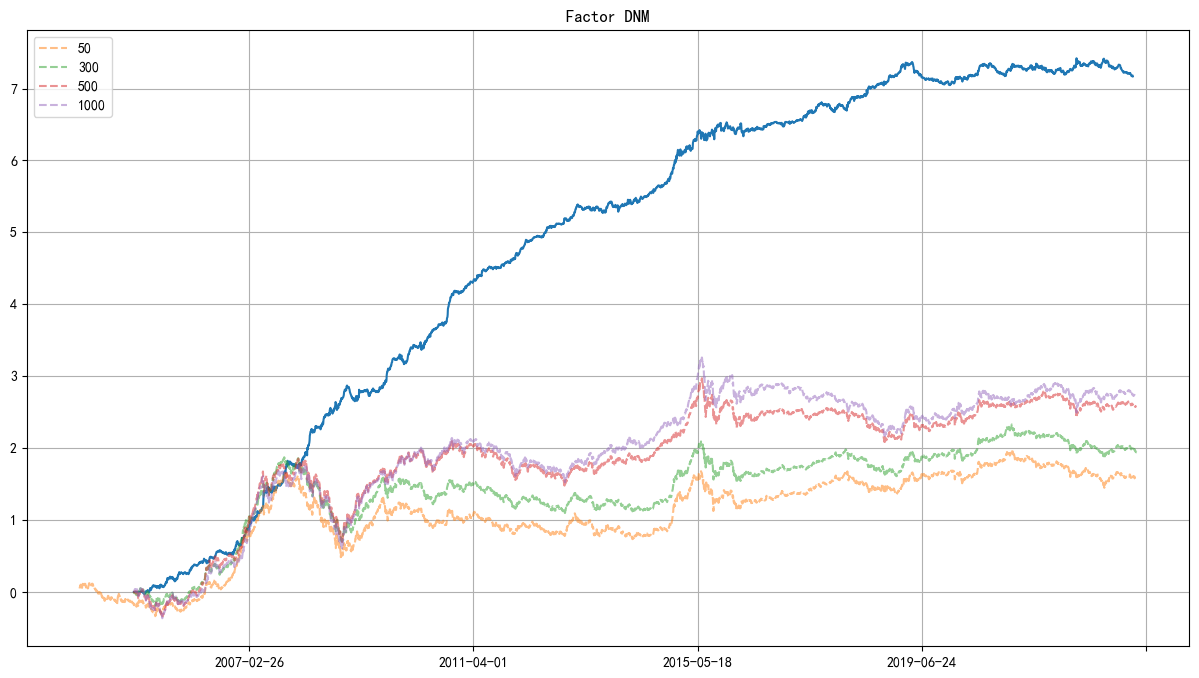

In [1517]:
# 单因子强弱
DNM_select2222, DNM_rets2222 = xy.single_Factor_backtest(
    # (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2017-01-07':].shift(1,axis=1),
    (DNexR).T.rolling(30).apply(lambda x:(x[-1]-x.min())/(x.max()-x.min())).T.loc[['50', '300', '500','1000'],:].shift(1,axis=1),
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50' , '300', '500', '1000'],:],
    _side=1,
    fee=0.000,
    name='DNM'
)

6850.0
yoy: 0.014192668693666961 
 mdd: -0.7688982351856636 
 sharpe: 0.0615253048980472 
 rankIC: -0.016045197740112992 
 rankIR: -0.016045450191433237 
 win%: 0.4885547576301616 
 gain_loss%: -1.0441916169736563


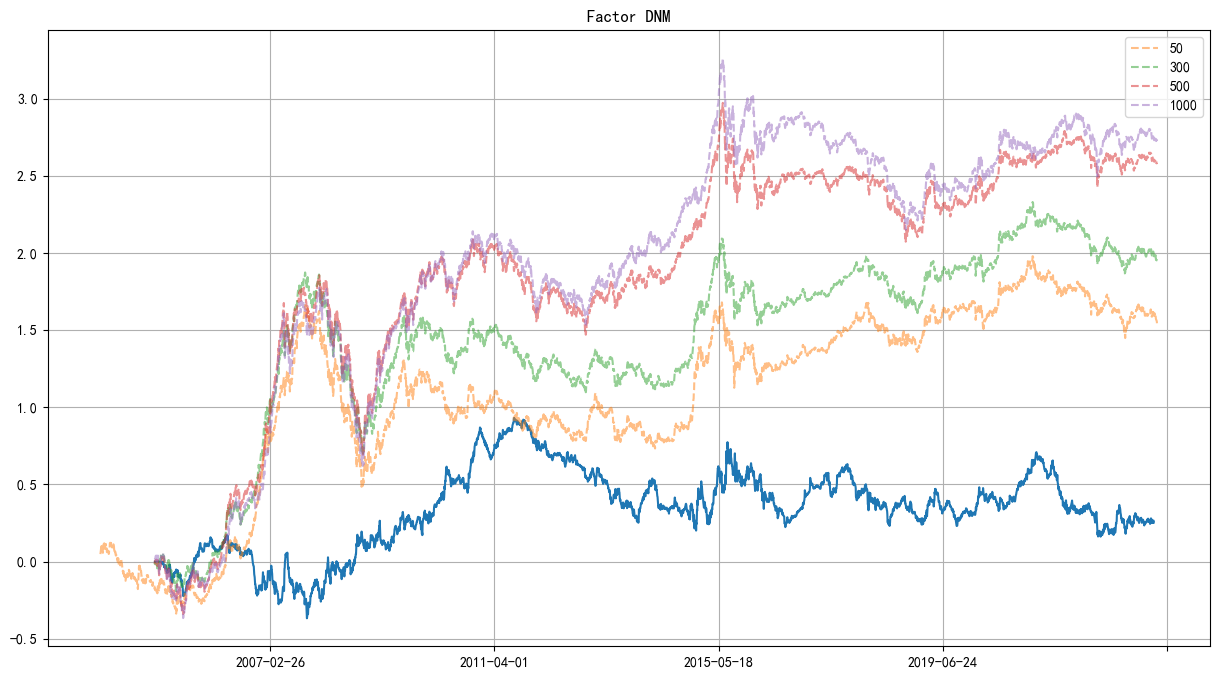

In [1498]:
# 单因子强弱
DNM_select3333, DNM_rets3333 = xy.single_Factor_backtest(
    # (exR).T.rolling(13,min_periods=1).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2017-01-07':].shift(1,axis=1),
    (ONexR).T.rolling(30).apply(lambda x:(x[-1]-x.min())/(x.max()-x.min())).T.loc[['50', '1000'],:].shift(1,axis=1),
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],:],
    _side=1,
    fee=0.00,
    name='DNM'
)

<Axes: >

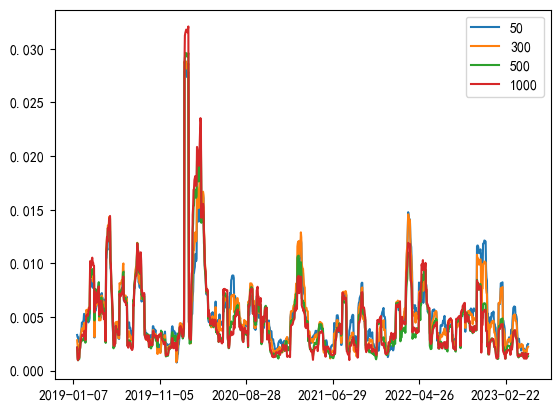

In [1118]:
ON.loc[['50', '300', '500', '1000'],'2019-01-07':].T.rolling(10).std().plot()

In [1335]:
((DN+1)*(ON+1)-1).T[['50', '1000']].dropna()

50      1000
2005-01-05  0.005268  0.023838
2005-01-06 -0.010739 -0.008009
2005-01-07  0.001358  0.006241
2005-01-10  0.011377  0.011760
2005-01-11  0.005852  0.003440
...              ...       ...
2023-05-04  0.005577  0.001586
2023-05-05 -0.002792 -0.011927
2023-05-08  0.013090  0.007341
2023-05-09 -0.006024 -0.013557
2023-05-10 -0.011106  0.002371

[4456 rows x 2 columns]

846.0
yoy: 0.3513827343995113 
 mdd: -0.2884173238919292 
 sharpe: 1.4642162562908296 
 rankIC: 0.06954225352112677 
 rankIR: 0.0696956804061343 
 win%: 0.5345358556973163 
 gain_loss%: -1.1266675119898792


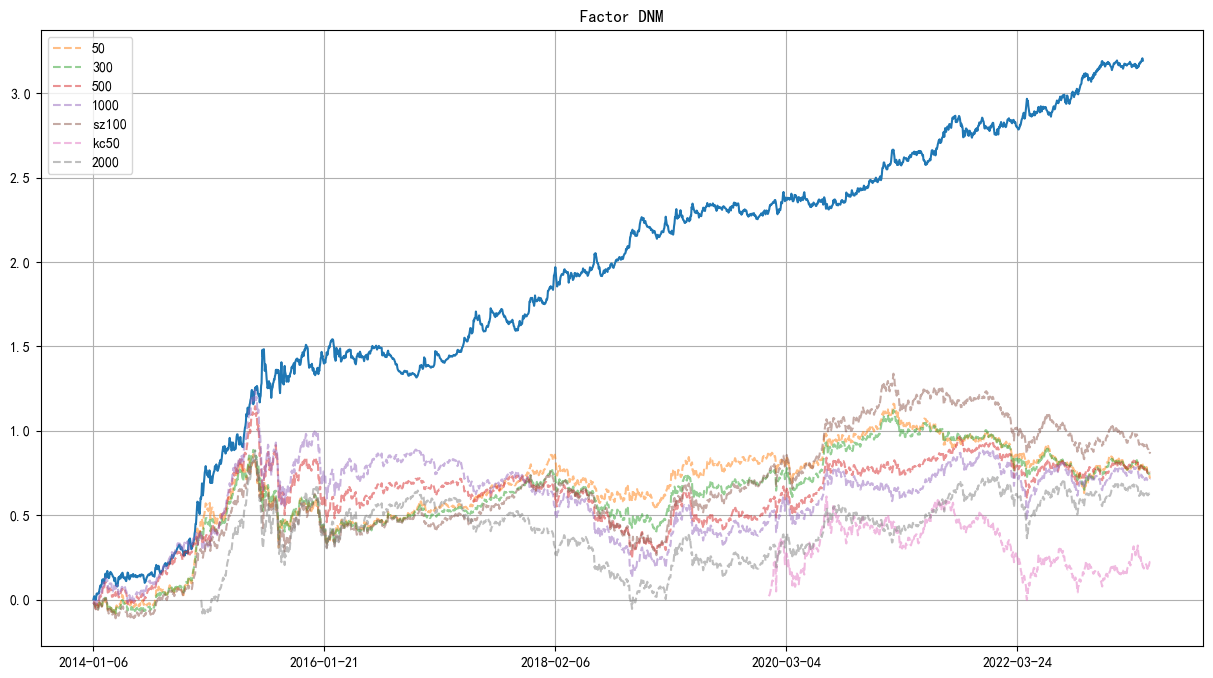

In [1360]:
# 单因子强弱
DNM_select, DNM_rets = xy.single_Factor_backtest(
    ((DN+1)*(ON+1)-1).T[['50', '300', '500', '1000']].dropna().rolling(13).apply(lambda x:x.mean()).T.loc[['50', '1000'],'2014-01-04':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[:,'2014-01-04':],
    _side=1,
    fee=0.00,
    name='DNM'
)

942.0
yoy: 0.24153346237137158 
 mdd: -0.6871554036180962 
 sharpe: 1.004203139272735 
 rankIC: 0.06514084507042253 
 rankIR: 0.06526512584941217 
 win%: 0.5323361196656401 
 gain_loss%: -1.0478605022576193


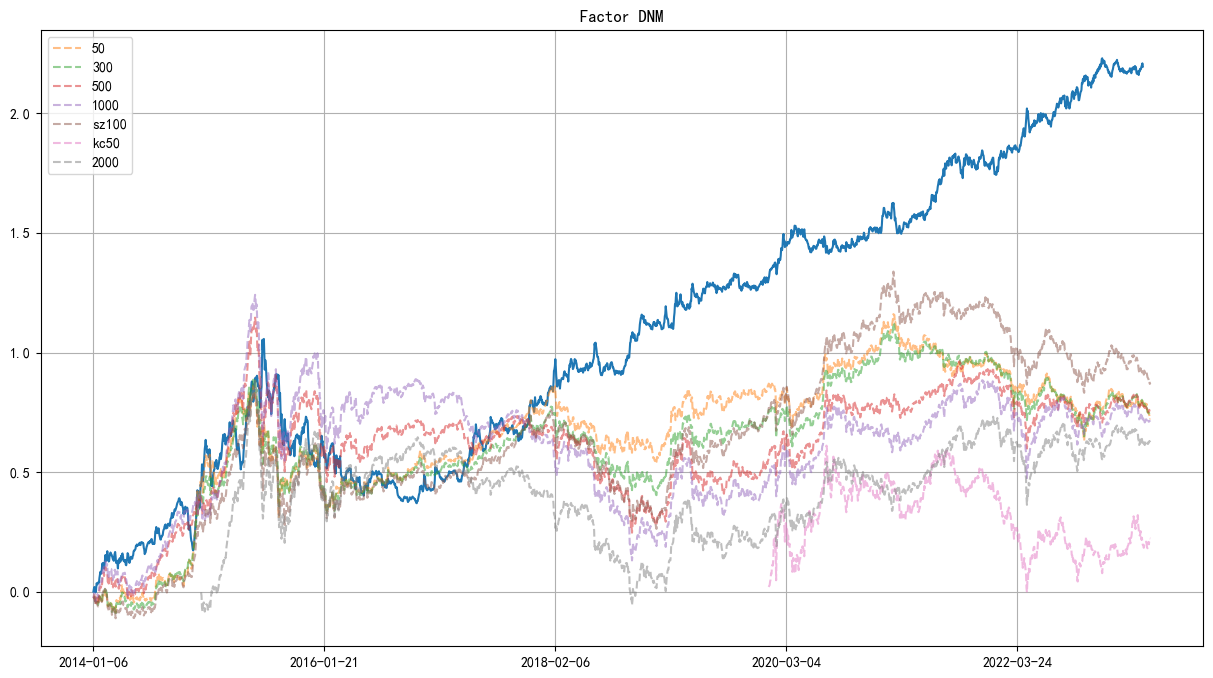

In [1356]:
# 单因子强弱
DNM_select, DNM_rets = xy.single_Factor_backtest(
    ((DN)).T[['50', '300', '500', '1000']].dropna().rolling(13).apply(lambda x:x.mean()).T.loc[['50', '1000'],'2014-01-04':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[:,'2014-01-04':],
    _side=1,
    fee=0.00,
    name='DNM'
)

866.0
yoy: 0.0876018439100392 
 mdd: -0.7404064300689304 
 sharpe: 0.36354961384511975 
 rankIC: -0.01453104359313078 
 rankIR: -0.014529378008824067 
 win%: 0.4925176056338028 
 gain_loss%: -1.0976775199072943


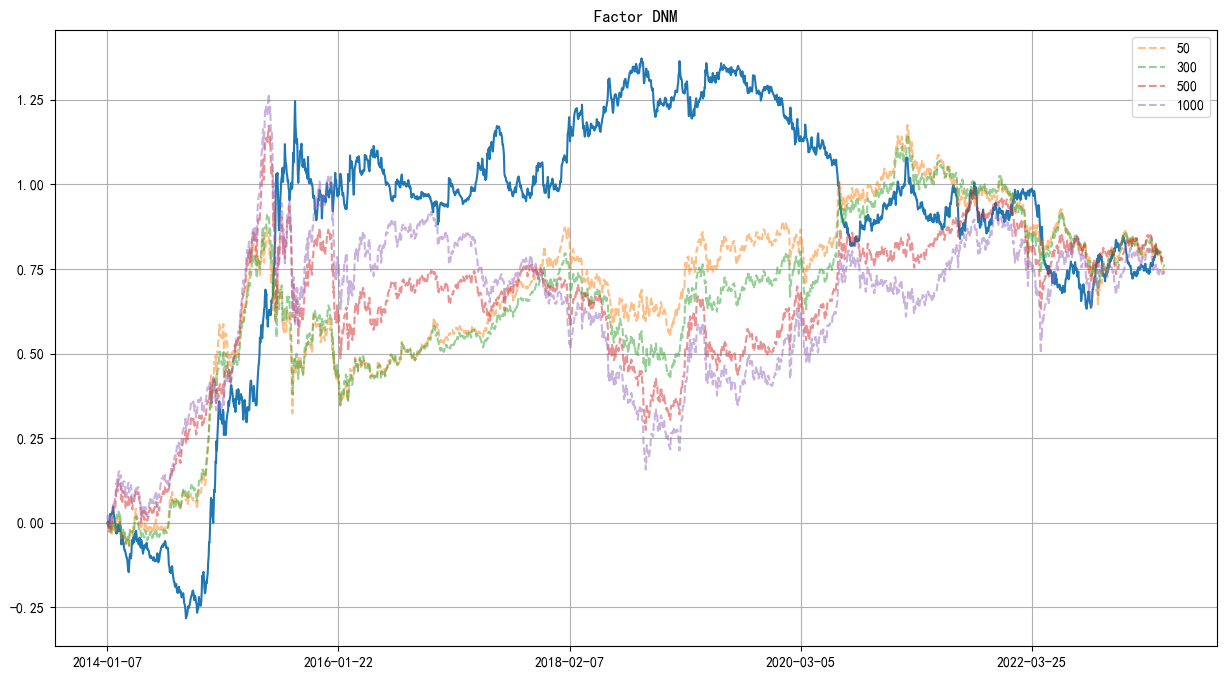

In [1357]:
# 单因子强弱
DNM_select, DNM_rets = xy.single_Factor_backtest(
    (ON).T[['50', '300', '500', '1000']].dropna().rolling(12).apply(lambda x:x.mean()).T.loc[['50', '1000'],'2014-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2014-01-07':],
    _side=1,
    fee=0.00,
    name='DNM'
)

742.0
yoy: -0.04926781483605097 
 mdd: -1.4018765472712063 
 sharpe: -0.2195617938324593 
 rankIC: -0.07488622258998759 
 rankIR: -0.0750815520662349 
 win%: 0.4602717167558666 
 gain_loss%: -1.1190599872987557


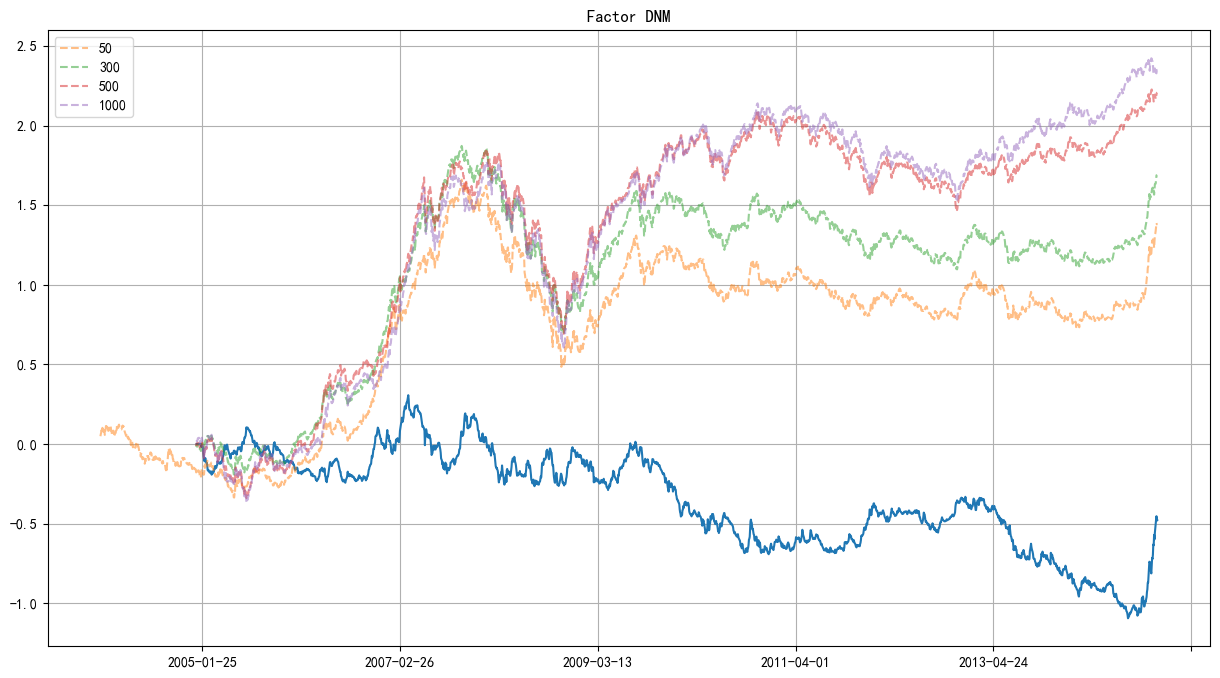

In [1361]:
# 单因子强弱
DNM_select, DNM_rets = xy.single_Factor_backtest(
    (ON).T[['50', '300', '500', '1000']].dropna().rolling(12).apply(lambda x:x.mean()).T.loc[['50', '1000'],:'2015-01-07'].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],:'2015-01-07'],
    _side=1,
    fee=0.00,
    name='DNM'
)

370.0
yoy: 0.4760370006280812 
 mdd: -0.24638318558531214 
 sharpe: 1.7760251494387616 
 rankIC: 0.06140350877192982 
 rankIR: 0.061492606559286185 
 win%: 0.530236634531113 
 gain_loss%: -1.2258417809377462


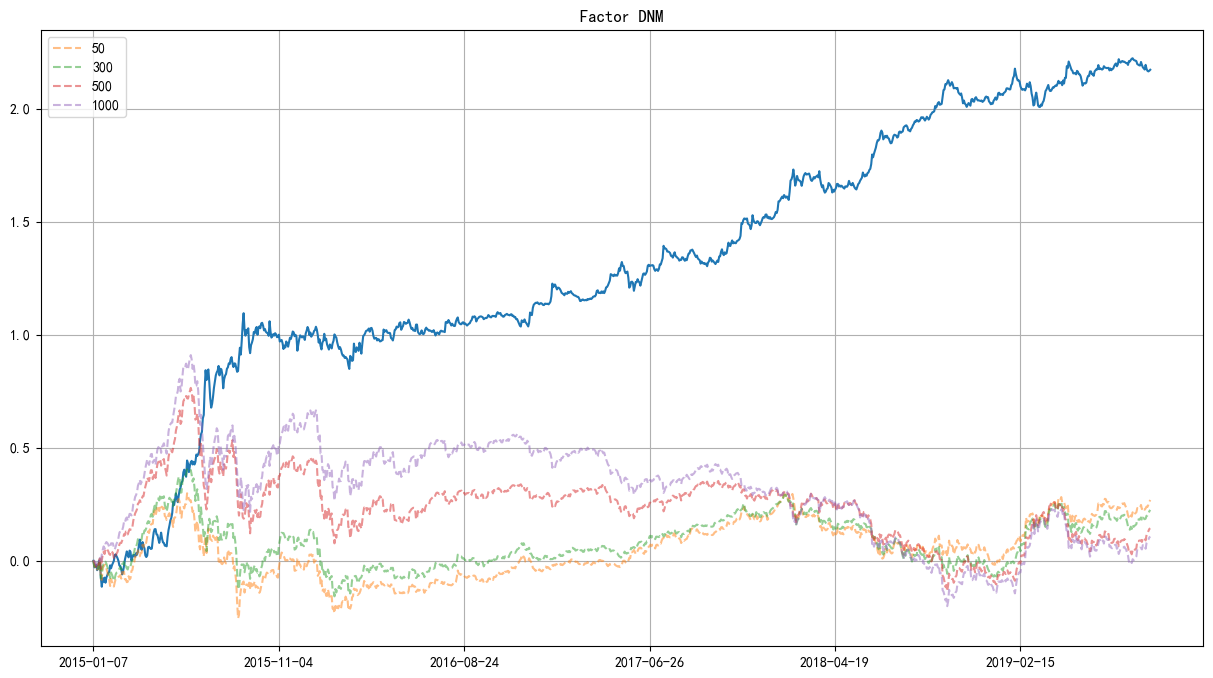

In [1215]:
# 单因子强弱
DNM_select, DNM_rets = xy.single_Factor_backtest(
    (ON).T[['50', '300', '500', '1000']].dropna().rolling(12).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2015-01-07':'2019-09-07'].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2015-01-07':'2019-09-07'],
    _side=1,
    fee=0.00,
    name='DNM'
)

In [1229]:
xy.Index_rets.loc[['50', '300', '500', '1000'],'2019-09-07':].T.rolling(20).std().mean(axis=1).mean()

0.012208422166900972

In [1228]:
xy.Index_rets.loc[['50', '300', '500', '1000'],'2015-01-07':'2019-09-07'].T.rolling(20).std().mean(axis=1).mean()

0.015153679057534408

In [1227]:
xy.Index_rets.loc[['50', '300', '500', '1000'],:'2015-01-07'].T.rolling(20).std().mean(axis=1).mean()

0.017127586227849875

370.0
yoy: 0.4760370006280812 
 mdd: -0.24638318558531214 
 sharpe: 1.7760251494387616 
 rankIC: 0.06140350877192982 
 rankIR: 0.061492606559286185 
 win%: 0.530236634531113 
 gain_loss%: -1.2258417809377462


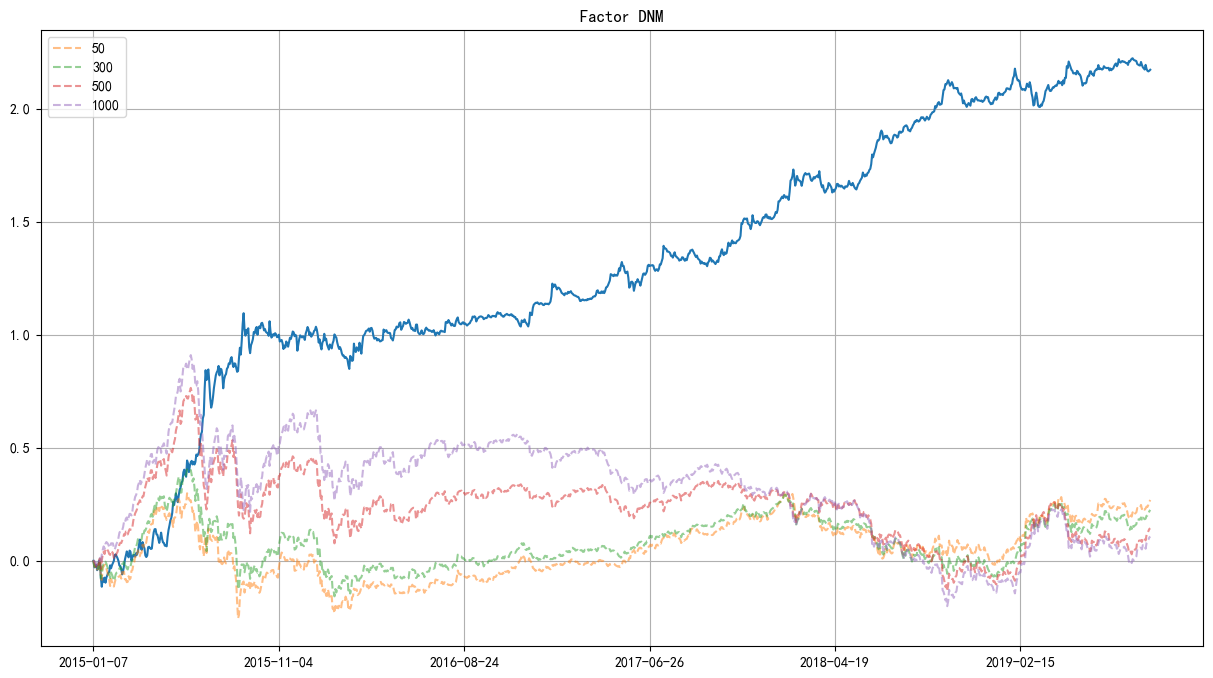

In [1238]:
# 单因子强弱
DNM_select, DNM_rets = xy.single_Factor_backtest(
    (ON).T[['50', '300', '500', '1000']].dropna().rolling(12).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2015-01-07':'2019-09-07'].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2015-01-07':'2019-09-07'],
    _side=1,
    fee=0.00,
    name='DNM'
)

726.0
yoy: -0.08136591776750986 
 mdd: -1.93422046329254 
 sharpe: -0.3626672773931173 
 rankIC: -0.08729830368225072 
 rankIR: -0.08761473678429843 
 win%: 0.45409633594071636 
 gain_loss%: -1.1196229687309598


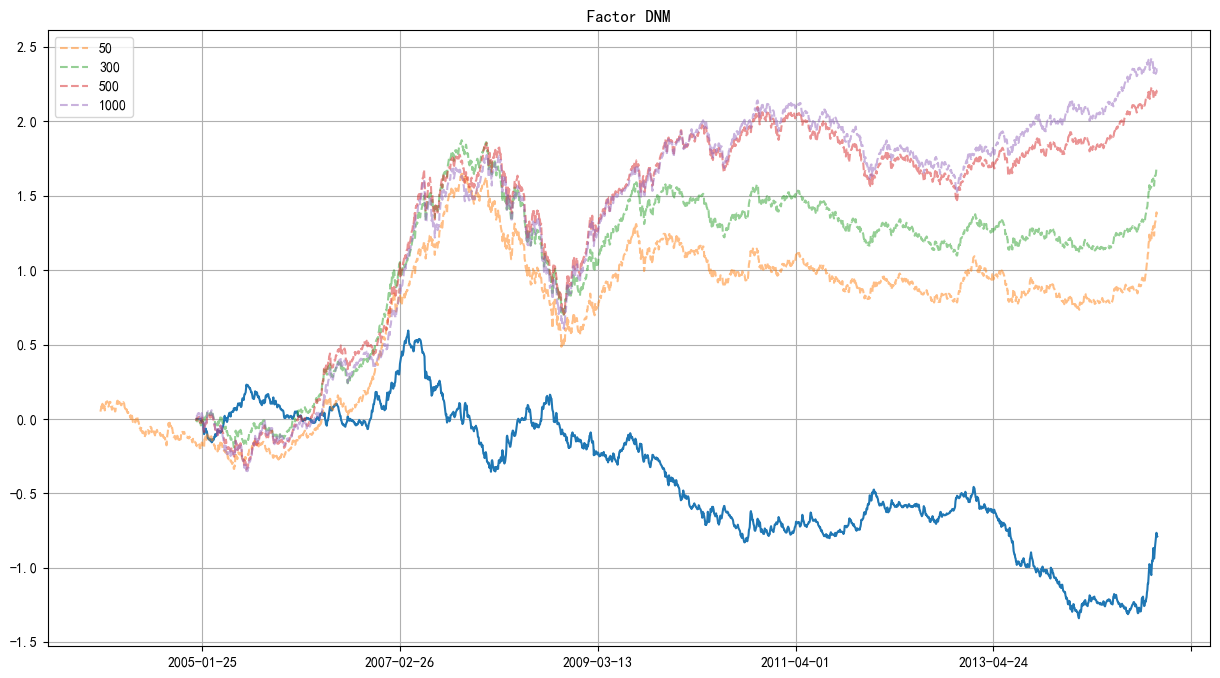

In [1236]:
# 单因子强弱
DNM_select, DNM_rets = xy.single_Factor_backtest(
    (ON).T[['50', '300', '500', '1000']].dropna().rolling(12).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],:'2015-01-07'].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],:'2015-01-07'],
    _side=1,
    fee=0.00,
    name='DNM'
)

434.0
yoy: 0.04804421390876315 
 mdd: -0.31357306181221445 
 sharpe: 0.2496711186327396 
 rankIC: -0.009029345372460492 
 rankIR: -0.009024616258300866 
 win%: 0.49492671927846676 
 gain_loss%: -1.0596603055008413


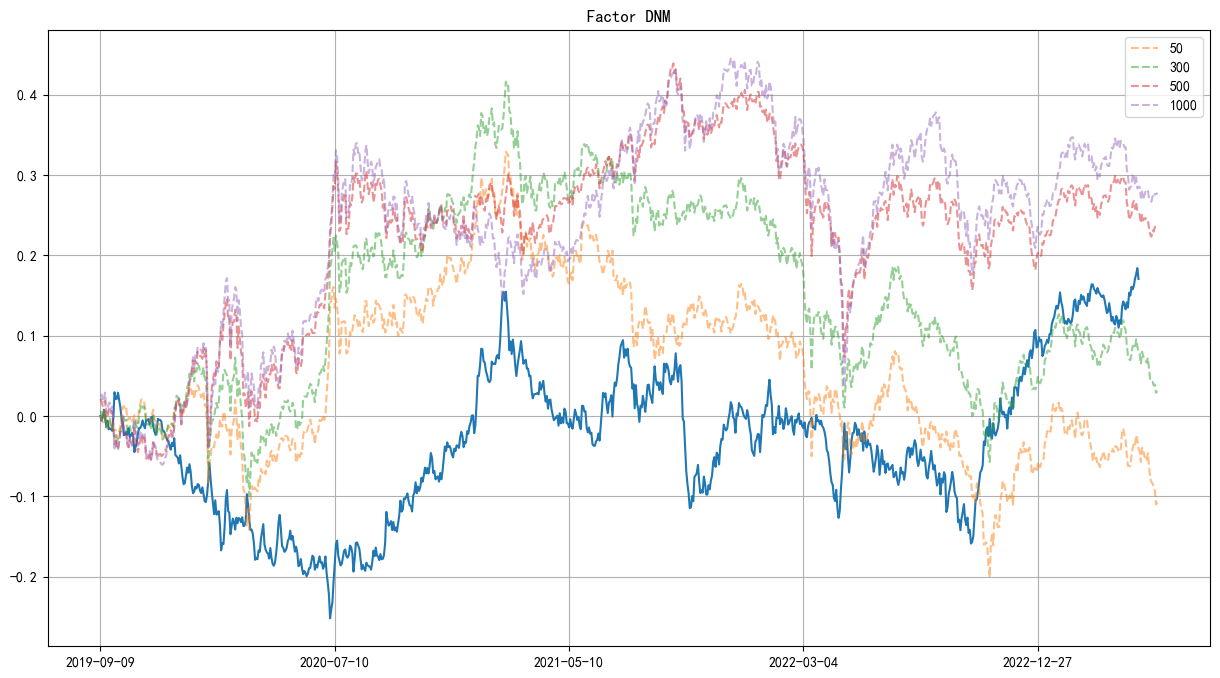

In [1217]:
# 单因子强弱
DNM_select, DNM_rets = xy.single_Factor_backtest(
    (ON).T[['50', '300', '500', '1000']].dropna().rolling(12).apply(lambda x:x.mean()/x.std()).T.loc[['50', '1000'],'2019-09-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.rolling(13).apply(lambda x:x[(x<x.max())&(x>x.min())].mean()/x[(x<x.max())&(x>x.min())].std()).T.loc[['50', '1000'],'2016-01-07':].shift(1,axis=1),
    # xy.Index_rets.loc[['50','1000'],:].T.shift(0).rolling(13).apply(lambda x:x[(x.abs()>0.00)].mean()/x[(x.abs()>0.00)].std()).T.shift(1,axis=1).loc[:,'2016-01-07':],
    # f.loc[['50', '300', '500', '1000'],'2016-02-28':].shift(1,axis=1),
    # f.T.shift(1).T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2019-09-07':],
    _side=1,
    fee=0.00,
    name='DNM'
)

In [517]:
import jqdatasdk
jqdatasdk.auth(username='13602599243',password='JoinQuant897617209')

auth success 


In [507]:
new_idx = []
for i in xy.weights1000.index:
    if i[-2:] == 'SZ':
        new_idx.append(i[:-3]+'.XSHE')
    else:
        new_idx.append(i[:-3]+'.XSHG')

['000005.XSHE',
 '000006.XSHE',
 '000008.XSHE',
 '000010.XSHE',
 '000011.XSHE',
 '000014.XSHE',
 '000016.XSHE',
 '000018.XSHE',
 '000019.XSHE',
 '000025.XSHE',
 '000028.XSHE',
 '000029.XSHE',
 '000030.XSHE',
 '000032.XSHE',
 '000034.XSHE',
 '000035.XSHE',
 '000036.XSHE',
 '000038.XSHE',
 '000040.XSHE',
 '000042.XSHE',
 '000048.XSHE',
 '000049.XSHE',
 '000055.XSHE',
 '000056.XSHE',
 '000058.XSHE',
 '000059.XSHE',
 '000061.XSHE',
 '000065.XSHE',
 '000070.XSHE',
 '000088.XSHE',
 '000089.XSHE',
 '000090.XSHE',
 '000096.XSHE',
 '000150.XSHE',
 '000151.XSHE',
 '000153.XSHE',
 '000155.XSHE',
 '000158.XSHE',
 '000159.XSHE',
 '000301.XSHE',
 '000403.XSHE',
 '000404.XSHE',
 '000407.XSHE',
 '000409.XSHE',
 '000410.XSHE',
 '000416.XSHE',
 '000419.XSHE',
 '000422.XSHE',
 '000423.XSHE',
 '000426.XSHE',
 '000428.XSHE',
 '000429.XSHE',
 '000488.XSHE',
 '000498.XSHE',
 '000503.XSHE',
 '000506.XSHE',
 '000507.XSHE',
 '000514.XSHE',
 '000516.XSHE',
 '000517.XSHE',
 '000518.XSHE',
 '000520.XSHE',
 '000521

In [189]:
Index_turnover = pd.concat([
    (xy.turns*xy.weights50).dropna(how='all',axis=1).sum().rename('50'),
    (xy.turns*xy.weights300).dropna(how='all',axis=1).sum().rename('300'),
    (xy.turns*xy.weights500).dropna(how='all',axis=1).sum().rename('500'),
    (xy.turns*xy.weights1000).dropna(how='all',axis=1).sum().rename('1000')
],axis=1).shift(1).T

In [179]:
Index_OrgMom = pd.concat([
    (Orig_Mom*xy.weights50).dropna(how='all',axis=1).sum().rename('50'),
    (Orig_Mom*xy.weights300).dropna(how='all',axis=1).sum().rename('300'),
    (Orig_Mom*xy.weights500).dropna(how='all',axis=1).sum().rename('500'),
    (Orig_Mom*xy.weights1000).dropna(how='all',axis=1).sum().rename('1000')
],axis=1).T

In [388]:
def get_ovn_money_mom(ser):
    # 隔夜成交量,昨日最后5分钟量
    fore_ovn_money = pd.Series(np.nansum(xy.rolling_window(ser.money,5)[235::240],axis=1),ser[::240].index.map(lambda x: str(x)[:10]))

    # 隔夜动量
    open1min50 = ser[::240].open
    close1min50 = ser[239::240].close
    
    open1min50.index = open1min50.index.map(lambda x:str(x)[:10])
    close1min50.index = close1min50.index.map(lambda x:str(x)[:10])
    
    ovn_mom = (open1min50/close1min50.shift(1) - 1)
    
    return fore_ovn_money, ovn_mom

In [85]:
def tov_rank(x):
    xrk = x.rank()
    return list(xrk)

In [421]:
def inraday_mom(
    idx_name,
    Index_turnover,
    ret,
    winsize
):
    TRs1 = []
    TRs2 = []
    TRs3 = []
    TRs4 = []
    TRs5 = []
    dts = []
    for _, win in enumerate(Index_turnover.T[idx_name].rolling(winsize,min_periods=winsize)):
        if _ < winsize-1:
            # print(_)
            continue

        rk = win.rank()
        rt = ret.T[idx_name][_-winsize+1:_+1]
        TRs1.append(rt[rk < (winsize/5)+1].mean())
        TRs2.append(rt[(rk >= (winsize/5)+1)&(rk < 2*(winsize/5)+1)].mean())
        TRs3.append(rt[(rk >= 2*(winsize/5)+1)&(rk < 3*(winsize/5)+1)].mean())
        TRs4.append(rt[(rk >= 3*(winsize/5)+1)&(rk < 4*(winsize/5)+1)].mean())
        TRs5.append(rt[rk >= 4*(winsize/5)+1].mean())
        dts.append(rt.index[-1])
        
    return pd.Series(TRs1,dts),pd.Series(TRs2,dts),pd.Series(TRs3,dts),pd.Series(TRs4,dts),pd.Series(TRs5,dts)

In [421]:
def inraday_mom_all1(
    tov,
    winsize=20
):
    TRs1 = []
    dts = []
    for _, win in enumerate(tov.rolling(winsize,min_periods=winsize)):
        if _ < winsize-1:
            # print(_)
            continue

        rk = win.rank()
        rt = xy.ret[_-winsize+1:_+1]
        TRs1.append(rt[rk < (winsize/5)+1].mean())
        dts.append(rt.index[-1])
        
    return pd.Series(TRs1,dts)

def inraday_mom_all5(
    tov,
    winsize
):
    TRs5 = []
    dts = []
    for _, win in enumerate(tov.rolling(winsize,min_periods=winsize)):
        if _ < winsize-1:
            # print(_)
            continue

        rk = win.rank()
        rt = xy.ret[_-winsize+1:_+1]
        TRs5.append(rt[rk > 4*(winsize/5)+1].mean())
        dts.append(rt.index[-1])
        
    return pd.Series(TRs5,dts)

In [ ]:
trs50_1,trs50_2,trs50_3,trs50_4,trs50_5 = inraday_mom('50',Index_turnover,xy.Index_rets,20)
trs300_1,trs300_2,trs300_3,trs300_4,trs300_5 = inraday_mom('300',Index_turnover,xy.Index_rets,20)
trs500_1,trs500_2,trs500_3,trs500_4,trs500_5 = inraday_mom('500',Index_turnover,xy.Index_rets,20)
trs1000_1,trs1000_2,trs1000_3,trs1000_4,trs1000_5 = inraday_mom('1000',Index_turnover,xy.Index_rets,20)

In [486]:
TSR5 = pd.concat([
    trs50_5.rename('50'),
    trs300_5.rename('300'),
    trs500_5.rename('500'),
    trs1000_5.rename('1000')
],axis=1).T

TSR1 = pd.concat([
    trs50_1.rename('50'),
    trs300_1.rename('300'),
    trs500_1.rename('500'),
    trs1000_1.rename('1000')
],axis=1).T

New_TSR = (TSR5 - TSR5.mean())/TSR5.std() - (TSR1 - TSR1.mean())/TSR1.std()

### 隔夜动量

#### 计算

In [399]:
fore_ovn_money50, ovn_mom50 = get_ovn_money_mom(xy.IndexMin50jq)
fore_ovn_money300, ovn_mom300 = get_ovn_money_mom(xy.IndexMin300jq)
fore_ovn_money500, ovn_mom500 = get_ovn_money_mom(xy.IndexMin500jq)
fore_ovn_money1000, ovn_mom1000 = get_ovn_money_mom(xy.IndexMin1000jq)

In [403]:
fore_ovn_money

2009-01-05    2009-01-06    2009-01-07    2009-01-08    2009-01-09  \
50           NaN  8.250600e+08  8.135700e+08  7.307400e+08  6.344200e+08   
300          NaN  1.828710e+09  2.013940e+09  1.861210e+09  1.489030e+09   
500          NaN  7.935900e+08  9.751000e+08  9.623200e+08  8.130200e+08   
1000         NaN  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

        2009-01-12    2009-01-13    2009-01-14    2009-01-15    2009-01-16  \
50    6.769100e+08  5.158634e+08  4.247900e+08  1.107980e+09  6.541400e+08   
300   1.728810e+09  1.483170e+09  1.355240e+09  2.623140e+09  1.991300e+09   
500   9.227900e+08  8.786500e+08  8.295500e+08  1.235610e+09  1.157390e+09   
1000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

      ...    2023-05-10    2023-05-11    2023-05-12    2023-05-15  \
50    ...  1.991171e+09  1.458768e+09  1.271485e+09  1.599953e+09   
300   ...  7.481325e+09  6.114054e+09  5.458529e+09  6.106284e+09   
500   ...  4.312992e+09  3.974655e+09  3.701919e+09  4.238894e+09   
1000  ...  5.445847e+09  4.811376e+09  4.712436e+09  4.915385e+09   

        2023-05-16    2023-05-17    2023-05-18    2023-05-19    2023-05-22  \
50    1.657399e+09  1.008896e+09  1.180294e+09  1.028243e+09  1.299600e+09   
300   6.045430e+09  4.686187e+09  5.080390e+09  5.039014e+09  5.276711e+09   
500   3.918296e+09  3.400174e+09  3.324875e+09  3.491412e+09  3.938973e+09   
1000  4.815079e+09  4.122559e+09  4.339571e+09  4.773196e+09  4.808558e+09   

        2023-05-23  
50    1.248882e+09  
300   4.504931e+09  
500   3.235583e+09  
1000  4.283948e+09  

[4 rows x 3495 columns]

In [404]:
fore_ovn_money = pd.concat([
    fore_ovn_money50.rename('50'),
    fore_ovn_money300.rename('300'),
    fore_ovn_money500.rename('500'),
    fore_ovn_money1000.rename('1000')
],axis=1).shift(1).T

In [405]:
fore_ovn_mom

2009-01-05  2009-01-06  2009-01-07  2009-01-08  2009-01-09  2009-01-12  \
50           NaN   -0.005297         0.0   -0.014508   -0.003198   -0.005258   
300          NaN         NaN         NaN         NaN         NaN         NaN   
500          NaN         NaN         NaN         NaN         NaN         NaN   
1000         NaN         NaN         NaN         NaN         NaN         NaN   

      2009-01-13  2009-01-14  2009-01-15  2009-01-16  ...  2023-05-10  \
50     -0.011628         0.0   -0.012333    0.003112  ...   -0.001478   
300          NaN         NaN         NaN         NaN  ...   -0.000498   
500          NaN         NaN         NaN         NaN  ...   -0.000322   
1000         NaN         NaN         NaN         NaN  ...   -0.001894   

      2023-05-11  2023-05-12  2023-05-15  2023-05-16  2023-05-17  2023-05-18  \
50      0.003366   -0.001124   -0.000380    0.000746   -0.001122    0.002265   
300     0.002508   -0.000251    0.000509   -0.000250   -0.001760    0.001772   
500     0.000969   -0.000972   -0.000818    0.000000   -0.002443    0.001791   
1000    0.000756   -0.002270    0.000000    0.000381    0.000000   -0.000764   

      2023-05-19  2023-05-22  2023-05-23  
50     -0.003025   -0.000759    0.001504  
300    -0.002532   -0.000254    0.000757  
500    -0.001300   -0.000162    0.000000  
1000   -0.000761   -0.001515    0.000759  

[4 rows x 3495 columns]

In [406]:
fore_ovn_mom = pd.concat([
    ovn_mom50.rename('50'),
    ovn_mom300.rename('300'),
    ovn_mom500.rename('500'),
    ovn_mom1000.rename('1000')
],axis=1).T

In [407]:
ovn_trs50_1,ovn_trs50_2,ovn_trs50_3,ovn_trs50_4,ovn_trs50_5 = inraday_mom('50',fore_ovn_money,fore_ovn_mom,20)
ovn_trs300_1,ovn_trs300_2,ovn_trs300_3,ovn_trs300_4,ovn_trs300_5 = inraday_mom('300',fore_ovn_money,fore_ovn_mom,20)
ovn_trs500_1,ovn_trs500_2,ovn_trs500_3,ovn_trs500_4,ovn_trs500_5 = inraday_mom('500',fore_ovn_money,fore_ovn_mom,20)
ovn_trs1000_1,ovn_trs1000_2,ovn_trs1000_3,ovn_trs1000_4,ovn_trs1000_5 = inraday_mom('1000',fore_ovn_money,fore_ovn_mom,20)

In [408]:
ovn_TSR5 = pd.concat([
    ovn_trs50_5.rename('50'),
    ovn_trs300_5.rename('300'),
    ovn_trs500_5.rename('500'),
    ovn_trs1000_5.rename('1000')
],axis=1).shift(1).T

ovn_TSR1 = pd.concat([
    ovn_trs50_1.rename('50'),
    ovn_trs300_1.rename('300'),
    ovn_trs500_1.rename('500'),
    ovn_trs1000_1.rename('1000')
],axis=1).shift(1).T

New_ovn_TSR = (ovn_TSR5 - ovn_TSR5.mean())/ovn_TSR5.std() - (ovn_TSR1 - ovn_TSR1.mean())/ovn_TSR1.std()

-8.770686894034968e-05
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

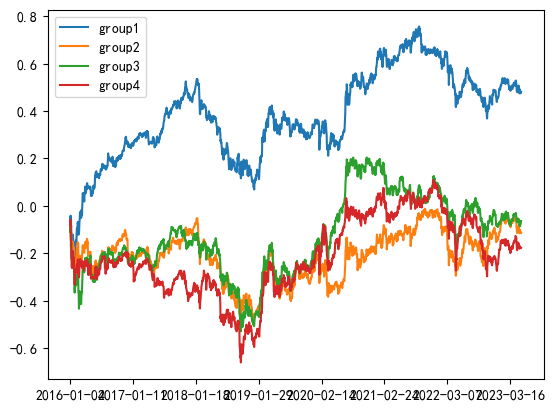

In [409]:
# 分组收益率
xy.cal_rate_group(
    New_ovn_TSR,
    xy.Index_rets,
    group_num=4,
    masks=1
).cumsum().plot()

#### 多头

shrh: 0.0 win%: 0.5179934569247546 gainloss%: -1.0500771309914925
shrh: 0.2 win%: 0.5184331797235023 gainloss%: -1.0457987586226194
shrh: 0.4 win%: 0.5264452644526445 gainloss%: -1.0940243752413124
shrh: 0.6 win%: 0.5328947368421053 gainloss%: -1.0777997288470291
shrh: 0.8 win%: 0.524024024024024 gainloss%: -1.0639112829064319


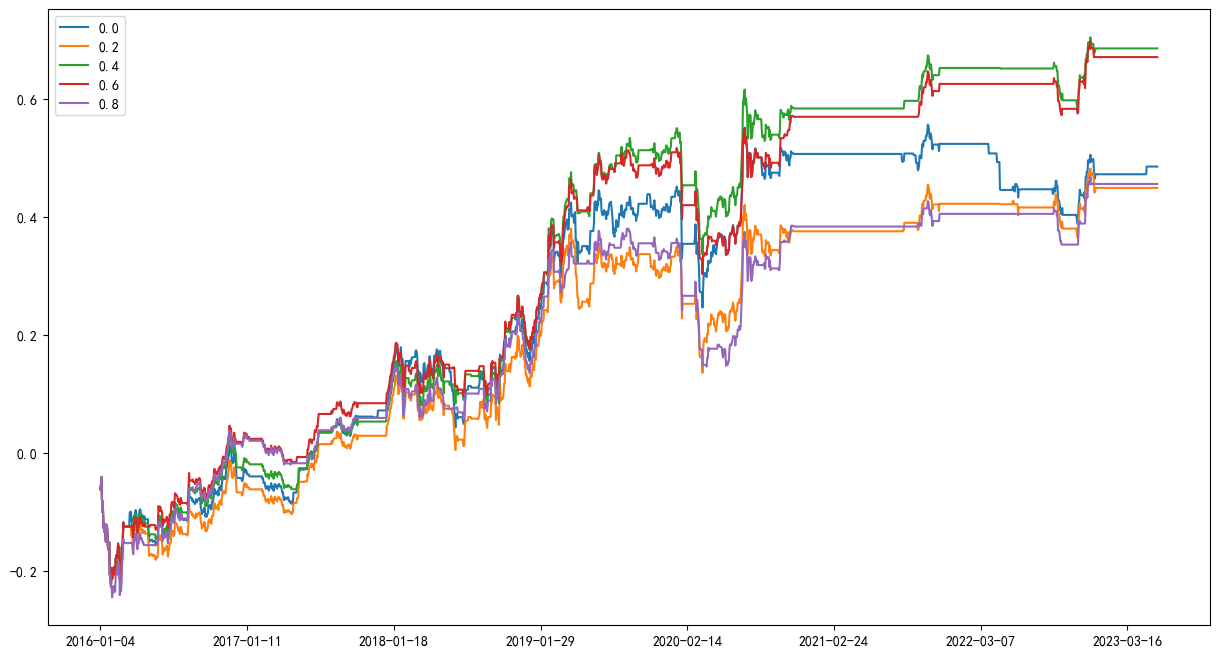

In [241]:
idx_name = '50'
for i in range(15)[::2]:
    i = i / 10
    same_dt = set(xy.Index_rets.T[idx_name].index) & set(New_TSR1_idx.T[idx_name].dropna().index)
    ts_ret = xy.Index_rets.T[idx_name].loc[New_TSR1_idx.T[idx_name][New_TSR1_idx.T[idx_name]>i].index&same_dt]
    
    if len(ts_ret) < 1:
        continue
        
    # if i < 1.4:
    #     continue

    win_pct = ts_ret[ts_ret>0].shape[0]/ts_ret.shape[0]
    win_loss_ratio = ts_ret[ts_ret>0].mean()/ts_ret[ts_ret<0].mean()
    
    print('shrh:',i, 'win%:', win_pct,'gainloss%:', win_loss_ratio)
    
    pd.Series(ts_ret.cumsum().rename(i),xy.Index_rets.T[idx_name].index).ffill().plot(legend=True,figsize=(15,8))
    
    if i == 0.8:
        break

In [238]:
ts_ret[ts_ret/ts_ret.shift()<0]

2016-01-05    0.007775
2016-01-07   -0.059137
2016-01-08    0.017896
2016-01-11   -0.044773
2016-01-12    0.005251
                ...   
2022-12-07   -0.005288
2022-12-08    0.000842
2022-12-12   -0.012118
2022-12-13    0.001107
2022-12-19   -0.015665
Name: 50, Length: 406, dtype: float64

#### 空头

shrh: 0.0 win%: 0.4976958525345622 gainloss%: -0.9456345567608521
shrh: 0.2 win%: 0.5036585365853659 gainloss%: -0.9324467286715544
shrh: 0.4 win%: 0.5065274151436031 gainloss%: -0.9112198314775933
shrh: 0.6 win%: 0.504297994269341 gainloss%: -0.9124547541108481


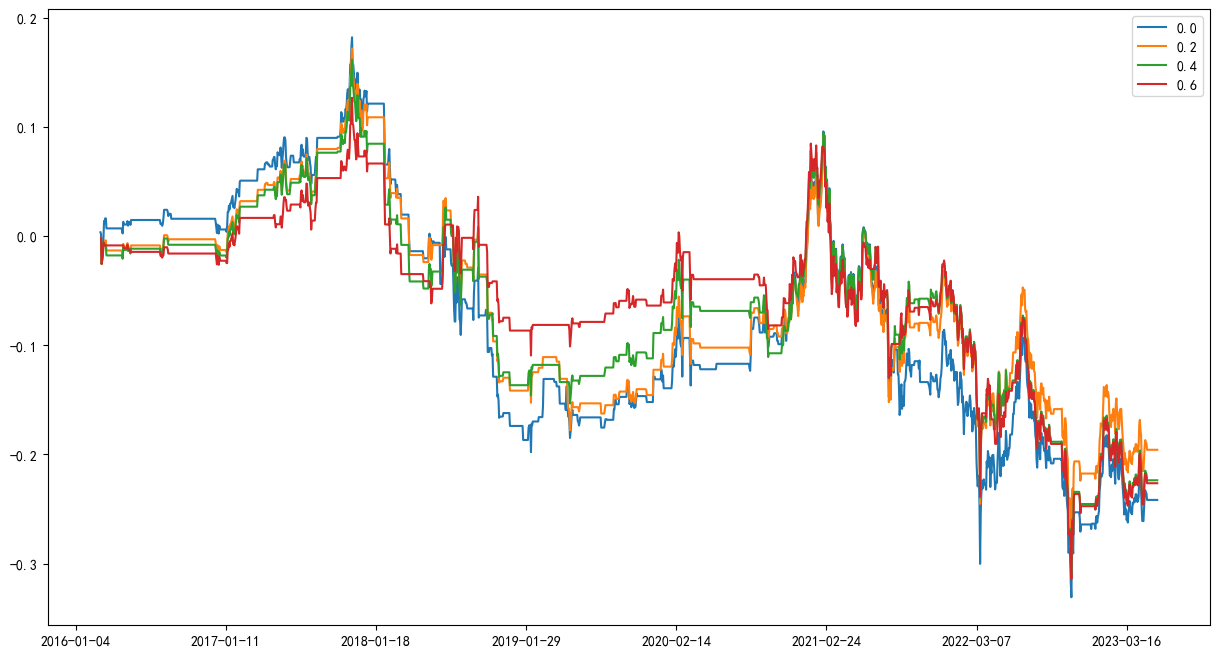

In [239]:
idx_name = '50'
for i in range(15)[::2]:
    i = i / 10
    same_dt = set(xy.Index_rets.T[idx_name].index) & set(New_TSR1_idx.T[idx_name].dropna().index)
    ts_ret = xy.Index_rets.T[idx_name].loc[New_TSR1_idx.T[idx_name][New_TSR1_idx.T[idx_name]<-i].index&same_dt]
    
    if len(ts_ret) < 1:
        continue
    
    
        
    win_pct = ts_ret[ts_ret>0].shape[0]/ts_ret.shape[0]
    win_loss_ratio = ts_ret[ts_ret>0].mean()/ts_ret[ts_ret<0].mean()
    print('shrh:',i, 'win%:', win_pct,'gainloss%:', win_loss_ratio)
    pd.Series(ts_ret.cumsum().rename(i), xy.Index_rets.T[idx_name].index).ffill().plot(legend=True,figsize=(15,8))
    
    if i == 0.6:
        break

In [240]:
ts_ret[ts_ret/ts_ret.shift()<0]

2016-03-11    0.004498
2016-03-17   -0.002175
2016-05-12    0.003092
2016-05-13   -0.004149
2016-08-02    0.000417
                ...   
2023-04-19   -0.008649
2023-04-25    0.000288
2023-04-26   -0.000479
2023-04-27    0.012449
2023-05-05   -0.002792
Name: 50, Length: 372, dtype: float64

## 评估

### cl-cl

-0.005304542389488867
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

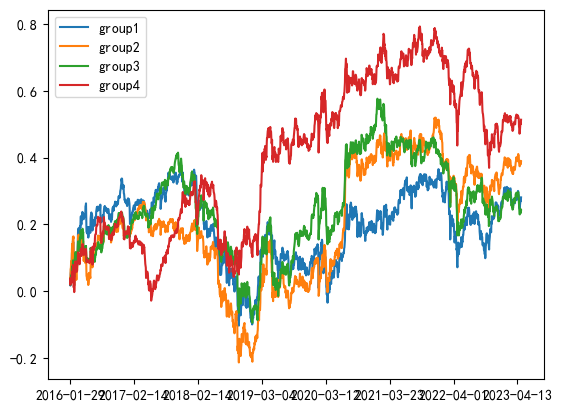

In [252]:
# 分组收益率
gr_ENPchange = xy.cal_rate_group(
    New_TSR,
    xy.Index_rets,
    group_num=4,
    masks=1
)
gr_ENPchange.cumsum().plot()

1200.0
yoy: 0.13930217658595143 
 mdd: -0.24263911959858697 
 sharpe: 0.8083180496890677 
 rankIC: 0.046514285714285716 
 rankIR: 0.060718360034692116 
 win%: 0.519327731092437 
 gain_loss%: -1.0222420349084191


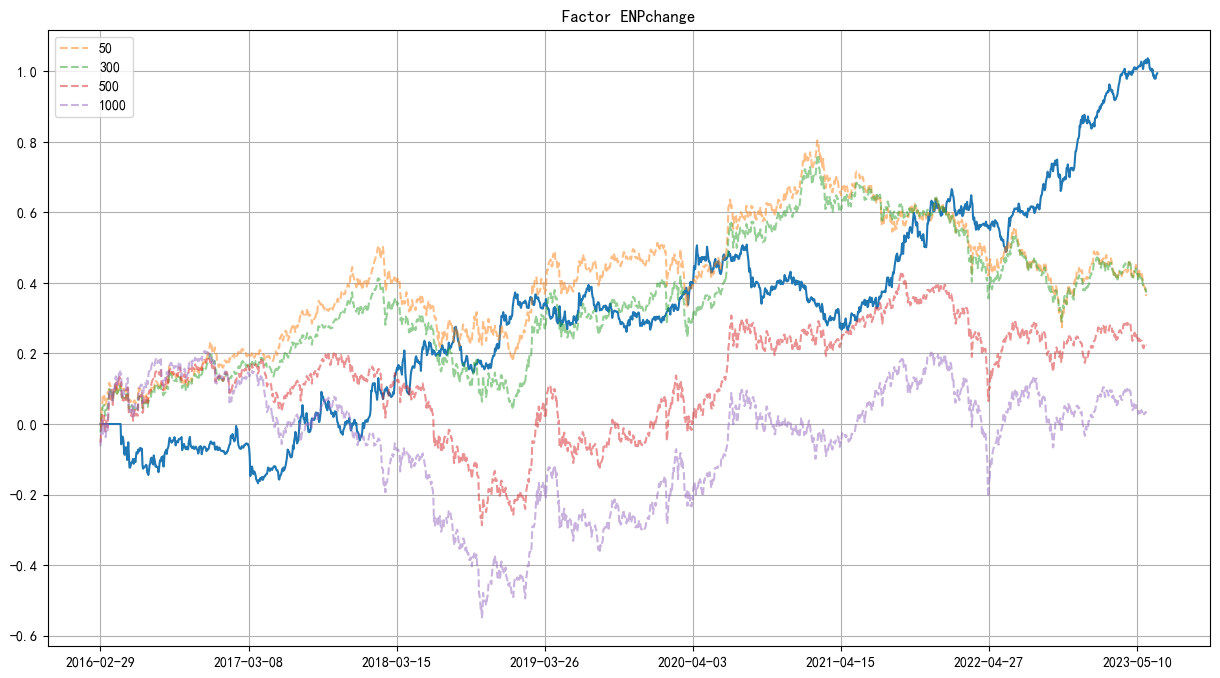

In [523]:
# 单因子强弱
ENPchange_select, ENPchange_rets = xy.single_Factor_backtest(
    New_TSR1_idx,
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    _side=1,
    fee=0.000,
    name='ENPchange'
)

0.046514285714285716

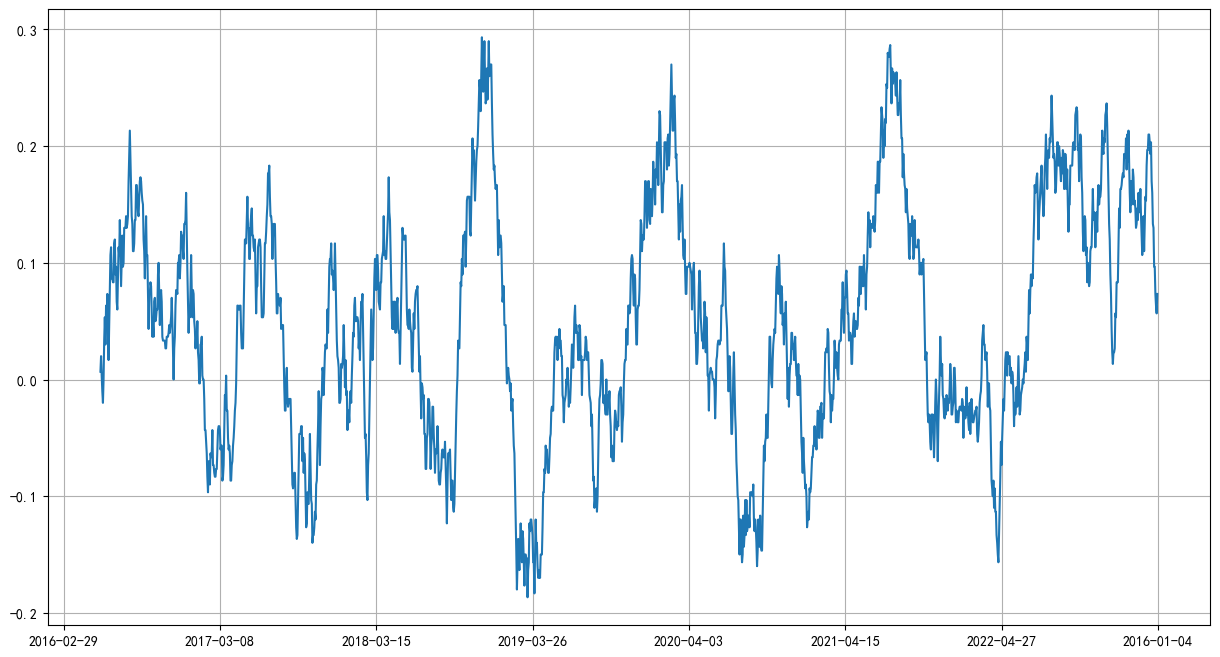

In [493]:
# 因子截面IC趋势
rankIC = xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False).corrwith(New_TSR1_idx.rank(ascending=False))
rankIC.rolling(60).mean().plot(figsize=(15,8),grid=1)
rankIC.mean()

### cl_op

-0.05012971921705416
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

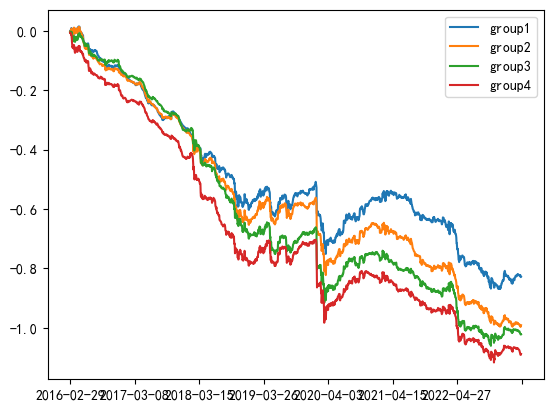

In [524]:
# 分组收益率
gr_ENPchange = xy.cal_rate_group(
    New_TSR1_idx.T.rolling(1).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    group_num=4,
    masks=1
)
gr_ENPchange.cumsum().plot()

1196.0
yoy: -0.037091003278173745 
 mdd: -0.31745989490437765 
 sharpe: -0.772221553049972 
 rankIC: -0.03474285714285715 
 rankIR: -0.0476398609918534 
 win%: 0.47314285714285714 
 gain_loss%: -0.9572870637371589


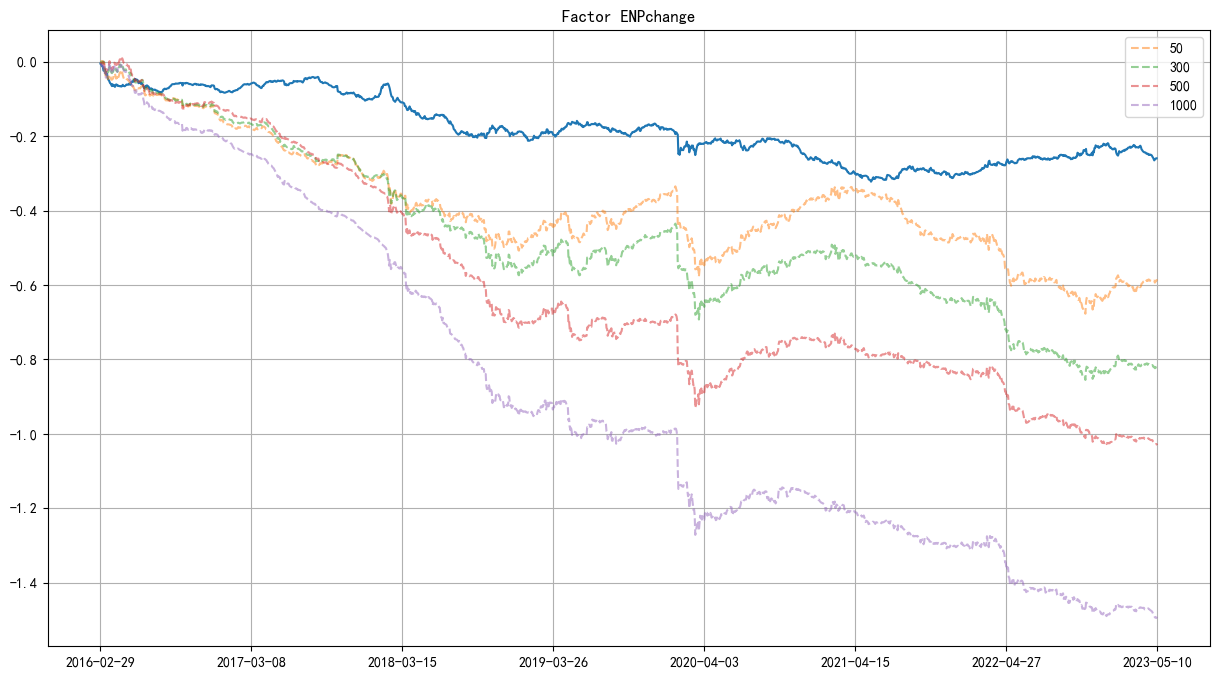

In [525]:
# 单因子强弱
ENPchange_select, ENPchange_rets = xy.single_Factor_backtest(
    New_TSR1_idx.T.rolling(1).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    _side=1,
    fee=0.000,
    name='ENPchange'
)

-0.03474285714285715

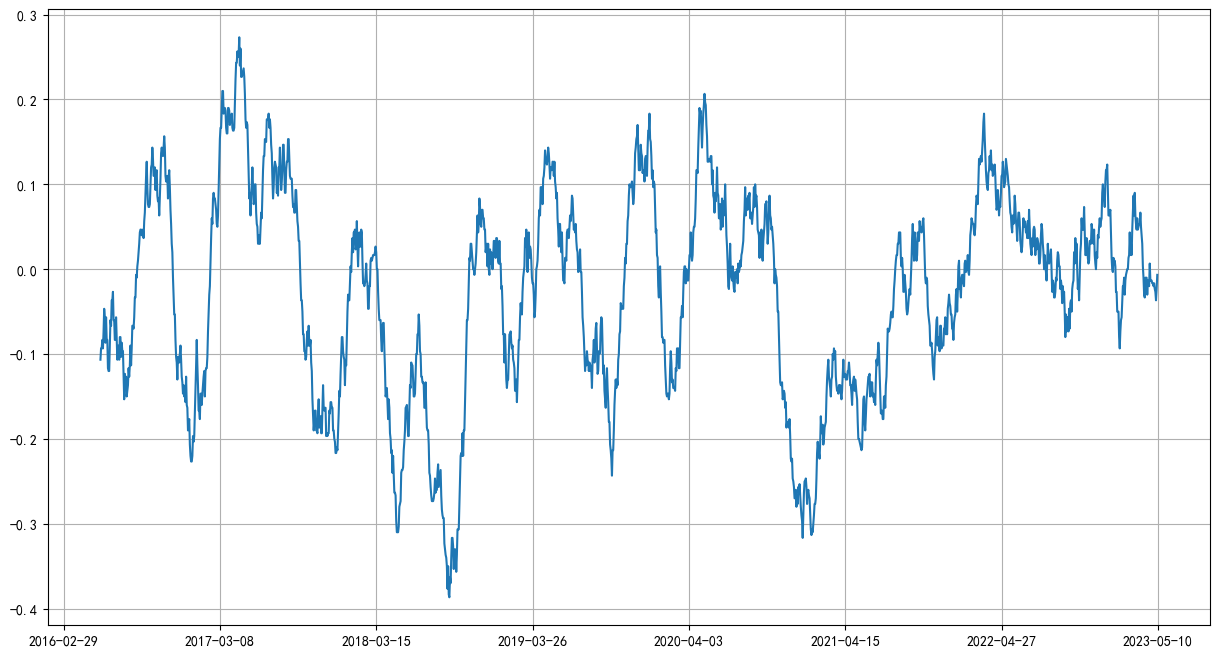

In [526]:
# 因子截面IC趋势
rankIC = xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False).corrwith(New_TSR1_idx.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False))
rankIC.rolling(60).mean().plot(figsize=(15,8),grid=1)
rankIC.mean()

### 择时

In [311]:
New_TSR

2016-01-29  2016-02-01  2016-02-02  2016-02-03  2016-02-04  2016-02-05  \
50      0.147235    0.226462    1.930968    1.764611    1.508440    1.616129   
300    -0.350651   -0.180354    1.422594    1.234912    1.238376    1.420999   
500     0.305772   -0.170631   -1.830181   -0.871996   -0.627495   -0.971579   
1000   -0.102355    0.124523   -1.523380   -2.127528   -2.119321   -2.065549   

      2016-02-15  2016-02-16  2016-02-17  2016-02-18  ...  2023-04-21  \
50      1.754330    1.857371    1.925839    1.925839  ...   -0.373158   
300     1.132818    0.808581    0.548959    0.548959  ...    0.329314   
500    -0.864574   -2.158523   -2.045980   -2.045980  ...    0.521820   
1000   -2.022574   -0.507429   -0.428817   -0.428817  ...   -0.477975   

      2023-04-24  2023-04-25  2023-04-26  2023-04-27  2023-04-28  2023-05-04  \
50      0.157809   -0.898556   -0.218572    0.507251    1.803494    2.533228   
300    -0.386280   -0.323111    0.273875   -1.049272   -1.349483   -1.132364   
500     0.278926    1.243249   -0.667052    0.253414   -0.787568   -1.161915   
1000   -0.050455   -0.021582    0.611749    0.288606    0.333557   -0.238948   

      2023-05-05  2023-05-08  2023-05-09  
50      2.403438    2.283654    2.237313  
300    -2.331592   -2.250266   -2.602437  
500    -0.249733   -0.459283    0.304789  
1000    0.177887    0.425895    0.060335  

[4 rows x 1766 columns]

<Axes: >

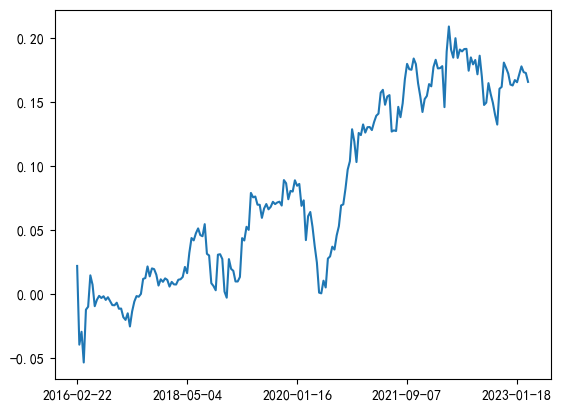

In [317]:
xy.Index_rets.T['300'].loc[New_TSR.T.dropna()['300'][New_TSR.T.dropna()['300']>1.5].index].cumsum().plot()

<Axes: >

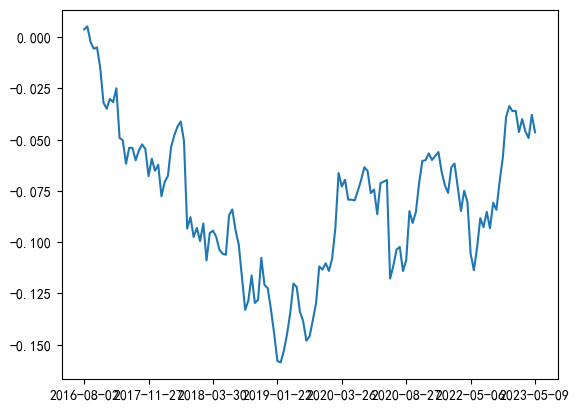

In [318]:
xy.Index_rets.T['300'].loc[New_TSR.T.dropna()['300'][New_TSR.T.dropna()['300']<-1.5].index].cumsum().plot()

In [25]:
ENPchange.to_csv(r'E:\PyProject\factors\NewFactor\st_ENPchg.csv')